The goal of this competition is to predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.

Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine. Using the information and labels in train.csv, you must predict the value for HasDetections for each machine in test.csv.

The sampling methodology used to create this dataset was designed to meet certain business constraints, both in regards to user privacy as well as the time period during which the machine was running. Malware detection is inherently a time-series problem, but it is made complicated by the introduction of new machines, machines that come online and offline, machines that receive patches, machines that receive new operating systems, etc. While the dataset provided here has been roughly split by time, the complications and sampling requirements mentioned above may mean you may see imperfect agreement between your cross validation, public, and private scores! Additionally, this dataset is not representative of Microsoft customers’ machines in the wild; it has been sampled to include a much larger proportion of malware machines.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split
from sklearn import tree, linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics



In [2]:
# set up display area to show dataframe in jupyter qtconsole
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Columns

Unavailable or self-documenting column names are marked with an "NA".

    MachineIdentifier - Individual machine ID
    ProductName - Defender state information e.g. win8defender
    EngineVersion - Defender state information e.g. 1.1.12603.0
    AppVersion - Defender state information e.g. 4.9.10586.0
    AvSigVersion - Defender state information e.g. 1.217.1014.0
    IsBeta - Defender state information e.g. false
    RtpStateBitfield - NA
    IsSxsPassiveMode - NA
    DefaultBrowsersIdentifier - ID for the machine's default browser
    AVProductStatesIdentifier - ID for the specific configuration of a user's antivirus software
    AVProductsInstalled - NA
    AVProductsEnabled - NA
    HasTpm - True if machine has tpm
    CountryIdentifier - ID for the country the machine is located in
    CityIdentifier - ID for the city the machine is located in
    OrganizationIdentifier - ID for the organization the machine belongs in, organization ID is mapped to both specific companies and broad industries
    GeoNameIdentifier - ID for the geographic region a machine is located in
    LocaleEnglishNameIdentifier - English name of Locale ID of the current user
    Platform - Calculates platform name (of OS related properties and processor property)
    Processor - This is the process architecture of the installed operating system
    OsVer - Version of the current operating system
    OsBuild - Build of the current operating system
    OsSuite - Product suite mask for the current operating system.
    OsPlatformSubRelease - Returns the OS Platform sub-release (Windows Vista, Windows 7, Windows 8, TH1, TH2)
    OsBuildLab - Build lab that generated the current OS. Example: 9600.17630.amd64fre.winblue_r7.150109-2022
    SkuEdition - The goal of this feature is to use the Product Type defined in the MSDN to map to a 'SKU-Edition' name that is useful in population reporting. The valid Product Type are defined in %sdxroot%\data\windowseditions.xml. This API has been used since Vista and Server 2008, so there are many Product Types that do not apply to Windows 10. The 'SKU-Edition' is a string value that is in one of three classes of results. The design must hand each class.
    IsProtected - This is a calculated field derived from the Spynet Report's AV Products field. Returns: a. TRUE if there is at least one active and up-to-date antivirus product running on this machine. b. FALSE if there is no active AV product on this machine, or if the AV is active, but is not receiving the latest updates. c. null if there are no Anti Virus Products in the report. Returns: Whether a machine is protected.
    AutoSampleOptIn - This is the SubmitSamplesConsent value passed in from the service, available on CAMP 9+
    PuaMode - Pua Enabled mode from the service
    SMode - This field is set to true when the device is known to be in 'S Mode', as in, Windows 10 S mode, where only Microsoft Store apps can be installed
    IeVerIdentifier - NA
    SmartScreen - This is the SmartScreen enabled string value from registry. This is obtained by checking in order, HKLM\SOFTWARE\Policies\Microsoft\Windows\System\SmartScreenEnabled and HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Explorer\SmartScreenEnabled. If the value exists but is blank, the value "ExistsNotSet" is sent in telemetry.
    Firewall - This attribute is true (1) for Windows 8.1 and above if windows firewall is enabled, as reported by the service.
    UacLuaenable - This attribute reports whether or not the "administrator in Admin Approval Mode" user type is disabled or enabled in UAC. The value reported is obtained by reading the regkey HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Policies\System\EnableLUA.
    Census_MDC2FormFactor - A grouping based on a combination of Device Census level hardware characteristics. The logic used to define Form Factor is rooted in business and industry standards and aligns with how people think about their device. (Examples: Smartphone, Small Tablet, All in One, Convertible...)
    Census_DeviceFamily - AKA DeviceClass. Indicates the type of device that an edition of the OS is intended for. Example values: Windows.Desktop, Windows.Mobile, and iOS.Phone
    Census_OEMNameIdentifier - NA
    Census_OEMModelIdentifier - NA
    Census_ProcessorCoreCount - Number of logical cores in the processor
    Census_ProcessorManufacturerIdentifier - NA
    Census_ProcessorModelIdentifier - NA
    Census_ProcessorClass - A classification of processors into high/medium/low. Initially used for Pricing Level SKU. No longer maintained and updated
    Census_PrimaryDiskTotalCapacity - Amount of disk space on primary disk of the machine in MB
    Census_PrimaryDiskTypeName - Friendly name of Primary Disk Type - HDD or SSD
    Census_SystemVolumeTotalCapacity - The size of the partition that the System volume is installed on in MB
    Census_HasOpticalDiskDrive - True indicates that the machine has an optical disk drive (CD/DVD)
    Census_TotalPhysicalRAM - Retrieves the physical RAM in MB
    Census_ChassisTypeName - Retrieves a numeric representation of what type of chassis the machine has. A value of 0 means xx
    Census_InternalPrimaryDiagonalDisplaySizeInInches - Retrieves the physical diagonal length in inches of the primary display
    Census_InternalPrimaryDisplayResolutionHorizontal - Retrieves the number of pixels in the horizontal direction of the internal display.
    Census_InternalPrimaryDisplayResolutionVertical - Retrieves the number of pixels in the vertical direction of the internal display
    Census_PowerPlatformRoleName - Indicates the OEM preferred power management profile. This value helps identify the basic form factor of the device
    Census_InternalBatteryType - NA
    Census_InternalBatteryNumberOfCharges - NA
    Census_OSVersion - Numeric OS version Example - 10.0.10130.0
    Census_OSArchitecture - Architecture on which the OS is based. Derived from OSVersionFull. Example - amd64
    Census_OSBranch - Branch of the OS extracted from the OsVersionFull. Example - OsBranch = fbl_partner_eeap where OsVersion = 6.4.9813.0.amd64fre.fbl_partner_eeap.140810-0005
    Census_OSBuildNumber - OS Build number extracted from the OsVersionFull. Example - OsBuildNumber = 10512 or 10240
    Census_OSBuildRevision - OS Build revision extracted from the OsVersionFull. Example - OsBuildRevision = 1000 or 16458
    Census_OSEdition - Edition of the current OS. Sourced from HKLM\Software\Microsoft\Windows NT\CurrentVersion@EditionID in registry. Example: Enterprise
    Census_OSSkuName - OS edition friendly name (currently Windows only)
    Census_OSInstallTypeName - Friendly description of what install was used on the machine i.e. clean
    Census_OSInstallLanguageIdentifier - NA
    Census_OSUILocaleIdentifier - NA
    Census_OSWUAutoUpdateOptionsName - Friendly name of the WindowsUpdate auto-update settings on the machine.
    Census_IsPortableOperatingSystem - Indicates whether OS is booted up and running via Windows-To-Go on a USB stick.
    Census_GenuineStateName - Friendly name of OSGenuineStateID. 0 = Genuine
    Census_ActivationChannel - Retail license key or Volume license key for a machine.
    Census_IsFlightingInternal - NA
    Census_IsFlightsDisabled - Indicates if the machine is participating in flighting.
    Census_FlightRing - The ring that the device user would like to receive flights for. This might be different from the ring of the OS which is currently installed if the user changes the ring after getting a flight from a different ring.
    Census_ThresholdOptIn - NA
    Census_FirmwareManufacturerIdentifier - NA
    Census_FirmwareVersionIdentifier - NA
    Census_IsSecureBootEnabled - Indicates if Secure Boot mode is enabled.
    Census_IsWIMBootEnabled - NA
    Census_IsVirtualDevice - Identifies a Virtual Machine (machine learning model)
    Census_IsTouchEnabled - Is this a touch device ?
    Census_IsPenCapable - Is the device capable of pen input ?
    Census_IsAlwaysOnAlwaysConnectedCapable - Retreives information about whether the battery enables the device to be AlwaysOnAlwaysConnected .
    Wdft_IsGamer - Indicates whether the device is a gamer device or not based on its hardware combination.
    Wdft_RegionIdentifier - NA


In [3]:
# We need to explicitly specify data types when reading csv, otherwise it is very memory consuming
# and we will get the warning "Specify dtype option on import or set low_memory=False"
# So, we will manually defined the data types

# P.S. I have loaded the sample data and exported train_data.dtypes
# these are the data types for fast loading

datatypes = {'ProductName': str, 'EngineVersion': str, 'AppVersion': str, 'AvSigVersion': str, 'IsBeta': np.int64,
    'RtpStateBitfield': np.float64, 'IsSxsPassiveMode': np.int64, 'DefaultBrowsersIdentifier': np.float64,
    'AVProductStatesIdentifier': np.float64, 'AVProductsInstalled': np.float64, 'AVProductsEnabled': np.float64,
    'HasTpm': np.int64, 'CountryIdentifier': np.int64, 'CityIdentifier': np.float64, 'OrganizationIdentifier': np.float64,
    'GeoNameIdentifier': np.float64, 'LocaleEnglishNameIdentifier': np.int64, 'Platform': str, 'Processor': str,
    'OsVer': str, 'OsBuild': np.int64, 'OsSuite': np.int64, 'OsPlatformSubRelease': str, 'OsBuildLab': str,
    'SkuEdition': str, 'IsProtected': np.float64, 'AutoSampleOptIn': np.int64, 'PuaMode': str, 'SMode': np.float64,
    'IeVerIdentifier': np.float64, 'SmartScreen': str, 'Firewall': np.float64, 'UacLuaenable': np.float64,
    'Census_MDC2FormFactor': str, 'Census_DeviceFamily': str, 'Census_OEMNameIdentifier': np.float64,
    'Census_OEMModelIdentifier': np.float64, 'Census_ProcessorCoreCount': np.float64, 
    'Census_ProcessorManufacturerIdentifier': np.float64, 'Census_ProcessorModelIdentifier': np.float64,
    'Census_ProcessorClass': str, 'Census_PrimaryDiskTotalCapacity': np.float64, 
    'Census_PrimaryDiskTypeName': str, 'Census_SystemVolumeTotalCapacity': np.float64,
    'Census_HasOpticalDiskDrive': np.int64, 'Census_TotalPhysicalRAM': np.float64, 'Census_ChassisTypeName': str,
    'Census_InternalPrimaryDiagonalDisplaySizeInInches': np.float64, 
    'Census_InternalPrimaryDisplayResolutionHorizontal': np.float64, 
    'Census_InternalPrimaryDisplayResolutionVertical': np.float64, 'Census_PowerPlatformRoleName': str,
    'Census_InternalBatteryType': str, 'Census_InternalBatteryNumberOfCharges': np.float64, 
    'Census_OSVersion': str, 'Census_OSArchitecture': str, 'Census_OSBranch': str, 'Census_OSBuildNumber': np.int64,
    'Census_OSBuildRevision': np.int64, 'Census_OSEdition': str, 'Census_OSSkuName': str, 
    'Census_OSInstallTypeName': str, 'Census_OSInstallLanguageIdentifier': np.float64, 
    'Census_OSUILocaleIdentifier': np.int64, 'Census_OSWUAutoUpdateOptionsName': str, 
    'Census_IsPortableOperatingSystem': np.int64, 'Census_GenuineStateName': str, 'Census_ActivationChannel': str,
    'Census_IsFlightingInternal': np.float64, 'Census_IsFlightsDisabled': np.float64, 'Census_FlightRing': str,
    'Census_ThresholdOptIn': np.float64, 'Census_FirmwareManufacturerIdentifier': np.float64, 
    'Census_FirmwareVersionIdentifier': np.float64, 'Census_IsSecureBootEnabled': np.int64, 
    'Census_IsWIMBootEnabled': np.float64, 'Census_IsVirtualDevice': np.float64, 'Census_IsTouchEnabled': np.int64,
    'Census_IsPenCapable': np.int64, 'Census_IsAlwaysOnAlwaysConnectedCapable': np.float64, 'Wdft_IsGamer': np.float64,
    'Wdft_RegionIdentifier': np.float64, 
    'HasDetections': np.int64}

#full_features = pd.read_csv("./csv/train.csv", dtype=datatypes, index_col="MachineIdentifier")
full_features = pd.read_csv("./csv/train.csv", dtype=datatypes, nrows=200000, index_col="MachineIdentifier")
full_labels = full_features["HasDetections"]

# Dropping labels ["HasDetections"] from training dataset
full_features = full_features.drop(["HasDetections"], axis=1)

In [4]:
print (full_features.shape)

(200000, 81)


In [5]:
# Checking the columns with the most NULL values
print((full_features.isnull().sum()).sort_values(ascending=False).head(10))

PuaMode                       199947
Census_ProcessorClass         199127
DefaultBrowsersIdentifier     190297
Census_IsFlightingInternal    166068
Census_InternalBatteryType    142088
Census_ThresholdOptIn         127008
Census_IsWIMBootEnabled       126839
SmartScreen                    71123
OrganizationIdentifier         61537
SMode                          11863
dtype: int64


In [6]:
full_features = full_features.drop(['PuaMode','Census_ProcessorClass','DefaultBrowsersIdentifier','Census_InternalBatteryType','Census_OSEdition','Census_IsFlightingInternal'], axis=1)

In [8]:
string_columns = []

for colname in full_features.dtypes.keys():
    if full_features[colname].dtypes.name == "object":
        string_columns.append(colname)
        
string_columns  

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'Platform',
 'Processor',
 'OsVer',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'SmartScreen',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_OSVersion',
 'Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_FlightRing']

In [9]:
full_features[string_columns].head(10)

,ProductName,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,,,,,
0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,NaN,Desktop,Windows.Desktop,HDD,Desktop,Desktop,10.0.17134.165,amd64,rs4_release,PROFESSIONAL,UUPUpgrade,UNKNOWN,IS_GENUINE,Retail,Retail
000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,NaN,Notebook,Windows.Desktop,HDD,Notebook,Mobile,10.0.17134.1,amd64,rs4_release,PROFESSIONAL,IBSClean,UNKNOWN,OFFLINE,Retail,NOT_SET
000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,RequireAdmin,Desktop,Windows.Desktop,SSD,Desktop,Desktop,10.0.17134.165,amd64,rs4_release,CORE,UUPUpgrade,FullAuto,IS_GENUINE,OEM:NONSLP,Retail
00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,ExistsNotSet,Desktop,Windows.Desktop,UNKNOWN,MiniTower,Desktop,10.0.17134.228,amd64,rs4_release,PROFESSIONAL,UUPUpgrade,FullAuto,IS_GENUINE,OEM:NONSLP,Retail
000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,RequireAdmin,Notebook,Windows.Desktop,HDD,Portable,Mobile,10.0.17134.191,amd64,rs4_release,CORE,Update,FullAuto,IS_GENUINE,Retail,Retail
000016191b897145d069102325cab760,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1094.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,RequireAdmin,Desktop,Windows.Desktop,SSD,Desktop,Desktop,10.0.17134.165,amd64,rs4_release,PROFESSIONAL,UUPUpgrade,FullAuto,IS_GENUINE,Retail,Retail
0000161e8abf8d8b89c5ab8787fd712b,win8defender,1.1.15100.1,4.18.1807.18075,1.273.845.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,NaN,Notebook,Windows.Desktop,HDD,Notebook,Mobile,10.0.17134.165,amd64,rs4_release,CORE,IBSClean,FullAuto,IS_GENUINE,Retail,Retail
000019515bc8f95851aff6de873405e8,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1393.0,windows10,x64,10.0.0.0,rs1,14393.0.amd64fre.rs1_release.160715-1616,Home,RequireAdmin,Notebook,Windows.Desktop,HDD,Notebook,Mobile,10.0.14393.0,amd64,rs1_release,CORE,Upgrade,FullAuto,IS_GENUINE,Retail,Retail
00001a027a0ab970c408182df8484fce,win8defender,1.1.15200.1,4.18.1807.18075,1.275.988.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,RequireAdmin,Notebook,Windows.Desktop,HDD,Notebook,Mobile,10.0.17134.254,amd64,rs4_release,PROFESSIONAL,Update,FullAuto,IS_GENUINE,Retail,Retail


At first glance at the data, it becomes obvious, that the stings are either classifiers, or versions that contain 4 classifiers in them. So. in order to use the algorithms that support only numeric values we will convert classifiers like "ProductName" to integer range and the fields like AppVersion

In [12]:
def df_replacevalues(df, colname, oldvalues, newvalues):
    # First, we need to get the most frequent value of the column
    topvalue = df[colname].value_counts().idxmax()
    
    # Replace NaN values with the popular value
    df[colname].fillna(topvalue, inplace=True)
    
    # We need to make sure no other value than oldvalues exists
    indexes = df[~df[colname].isin(oldvalues)].index
    
    # If the "Garbage" values are more than 1%, then raise an error
    if len(indexes) > len(df) / 100:
        raise Exception("Not all neccessary values are present in oldvalues array")
    
    # Replace "Garbage" with the top value
    df.loc[indexes,[colname]] = topvalue
    
    print ("Previous values", df[colname].unique())
    df[colname] = pd.to_numeric(df[colname].replace(oldvalues, newvalues), errors='raise', downcast='integer')
    print ("New values", df[colname].unique())
    
#full_features["Platform"].unique()
#full_features["Platform"].value_counts()
#full_features[~full_features["ProductName"].isin(['win8defender', 'mse'])].index

In [13]:
colname = "ProductName"
oldvalues = ['win8defender','mse','mseprerelease','windowsintune','fep','scep']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['win8defender' 'mse']
New values [1 2]


In [14]:
colname = "Platform"
oldvalues = ['windows10','windows7','windows8','windows2016']
newvalues = [10,7,8,2016]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['windows10' 'windows7' 'windows8' 'windows2016']
New values [  10    7    8 2016]


In [15]:
colname = "Processor"
oldvalues = ['x64','arm64','x86']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['x64' 'arm64' 'x86']
New values [1 2 3]


In [16]:
colname = "OsPlatformSubRelease"
oldvalues = ['rs4','rs1','rs3','windows7','windows8.1','th1','rs2','th2','prers5']
newvalues = [504,501,503,507,508,201,502,202,405]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['rs4' 'rs1' 'rs3' 'windows7' 'windows8.1' 'th1' 'rs2' 'th2' 'prers5']
New values [504 501 503 507 508 201 502 202 405]


In [17]:
colname = "SkuEdition"
oldvalues = ['Pro','Home','Invalid','Enterprise LTSB','Enterprise','Education','Cloud','Server']
newvalues = [55,52,0,71,70,20,90,80]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['Pro' 'Home' 'Invalid' 'Enterprise LTSB' 'Enterprise' 'Education' 'Cloud'
 'Server']
New values [55 52  0 71 70 20 90 80]


In [18]:
#"SmartScreen" column looks more complicated
# We will remove some garbage values and will use
# Only limited list of "good values"

full_features["SmartScreen"].value_counts()

RequireAdmin    96771
ExistsNotSet    23610
Off              4139
Warn             3002
Prompt            743
Block             532
off                35
On                 19
&#x01;             17
on                  5
&#x02;              4
Name: SmartScreen, dtype: int64

In [19]:
full_features["SmartScreen"].unique()

array([nan, 'RequireAdmin', 'ExistsNotSet', 'Off', 'Warn', 'Prompt',
       'Block', 'off', 'On', 'on', '&#x01;', '&#x02;'], dtype=object)

In [20]:
colname = "SmartScreen"
oldvalues = ['Off','off','OFF','On','on','Warn','Prompt','ExistsNotSet','Block','RequireAdmin']
newvalues = [0,0,0,1,1,2,3,4,5,6]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['RequireAdmin' 'ExistsNotSet' 'Off' 'Warn' 'Prompt' 'Block' 'off' 'On'
 'on']
New values [6 4 0 2 3 5 1]


In [21]:
colname = "Census_MDC2FormFactor"
oldvalues = ['Desktop','Notebook','Detachable','PCOther','AllInOne','Convertible','SmallTablet','LargeTablet','SmallServer','LargeServer','MediumServer','ServerOther','IoTOther']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['Desktop' 'Notebook' 'Detachable' 'PCOther' 'AllInOne' 'Convertible'
 'SmallTablet' 'LargeTablet' 'SmallServer' 'LargeServer' 'MediumServer'
 'ServerOther']
New values [ 1  2  3  4  5  6  7  8  9 10 11 12]


In [22]:
# Census_DeviceFamily ['Windows.Desktop' 'Windows.Server' 'Windows']

colname = "Census_DeviceFamily"
oldvalues = ['Windows.Desktop','Windows.Server','Windows']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['Windows.Desktop' 'Windows.Server']
New values [1 2]


In [23]:
# Census_PrimaryDiskTypeName ['HDD' 'SSD' 'UNKNOWN' 'Unspecified' nan]

colname = "Census_PrimaryDiskTypeName"
oldvalues = ['HDD','SSD','UNKNOWN','Unspecified']
newvalues = [1,2,3,3]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['HDD' 'SSD' 'UNKNOWN' 'Unspecified']
New values [1 2 3]


In [24]:
# Census_ChassisTypeName Index(['Notebook', 'Desktop', 'Laptop', 'Portable', 'AllinOne', 'MiniTower', 'Convertible', 'Other', 'UNKNOWN', 'Detachable', 'LowProfileDesktop', 'HandHeld', 'SpaceSaving', 'Tablet', 'Tower', 'Unknown', 'MainServerChassis', 'MiniPC', 'LunchBox', 'RackMountChassis', 'SubNotebook', 'BusExpansionChassis', '30', 'StickPC', '0', 'MultisystemChassis', 'Blade', '35', 'PizzaBox', 'SealedCasePC', 'SubChassis', 'ExpansionChassis', '31', '32', '88', '127', '25', '44', '36', 'DockingStation', 'BladeEnclosure', 'CompactPCI', '81', '45', 'EmbeddedPC', '28', '82', '112', 'IoTGateway', '49', '76', '39'], dtype='object')

colname = "Census_ChassisTypeName"
oldvalues = ['Notebook', 'Desktop', 'Laptop', 'Portable', 'AllinOne', 'MiniTower', 'Convertible', 'Other', 'UNKNOWN', 'Detachable', 
             'LowProfileDesktop', 'HandHeld', 'SpaceSaving', 'Tablet', 'Tower', 'Unknown', 'MainServerChassis', 'MiniPC', 'LunchBox', 
             'RackMountChassis', 'SubNotebook', 'BusExpansionChassis']
newvalues = [1,2,1,1,3,4,5,6,-1,7,8,9,10,11,12,-1,13,2,14,15,1,16]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['Desktop' 'Notebook' 'MiniTower' 'Portable' 'Detachable' 'Laptop'
 'AllinOne' 'LowProfileDesktop' 'SpaceSaving' 'Other' 'Unknown' 'HandHeld'
 'UNKNOWN' 'Convertible' 'Tower' 'MainServerChassis' 'LunchBox'
 'SubNotebook' 'MiniPC' 'RackMountChassis' 'Tablet' 'BusExpansionChassis']
New values [ 2  1  4  7  3  8 10  6 -1  9  5 12 13 14 15 11 16]


In [25]:
# Census_PowerPlatformRoleName Index(['Mobile', 'Desktop', 'Slate', 'Workstation', 'SOHOServer', 'UNKNOWN', 'EnterpriseServer', 'AppliancePC', 'PerformanceServer', 'Unspecified']

colname = "Census_PowerPlatformRoleName"
oldvalues = ['Mobile', 'Desktop', 'Slate', 'Workstation', 'SOHOServer', 'UNKNOWN', 'EnterpriseServer', 'AppliancePC', 'PerformanceServer', 'Unspecified']
newvalues = [1,2,3,2,4,-1,5,6,7,-1]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['Desktop' 'Mobile' 'Slate' 'Workstation' 'SOHOServer' 'UNKNOWN'
 'AppliancePC' 'EnterpriseServer' 'PerformanceServer']
New values [ 2  1  3  4 -1  6  5  7]


In [26]:
# Census_OSArchitecture Index(['amd64', 'x86', 'arm64'], dtype='object')

colname = "Census_OSArchitecture"
oldvalues = ['amd64', 'x86', 'arm64']
newvalues = [1,3,2]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['amd64' 'arm64' 'x86']
New values [1 2 3]


In [27]:
# Census_OSBranch Index(['rs4_release', 'rs3_release', 'rs3_release_svc_escrow', 'rs2_release', 'rs1_release', 'th2_release', 'th2_release_sec', 'th1_st1', 'th1', 'rs5_release', 'rs3_release_svc_escrow_im', 'rs_prerelease', 'rs_prerelease_flt', 'rs5_release_sigma', 'rs1_release_srvmedia', 'winblue_ltsb_escrow', 'win7sp1_ldr', 'winblue_ltsb', 'win8_gdr', 'rs_xbox', 'rs5_release_edge', 'rs5_release_sigma_dev', 'win7sp1_ldr_escrow', 'rs1_release_sec', 'rs_shell', 'rs1_release_svc', 'win8_ldr', 'rs_onecore_base_cobalt', 'rs_onecore_stack_per1', 'rs5_release_sign', 'rs3_release_svc', 'Khmer OS'], dtype='object')

colname = "Census_OSBranch"
oldvalues = ['rs4_release', 'rs3_release', 'rs3_release_svc_escrow', 'rs2_release', 'rs1_release', 'th2_release', 'th2_release_sec', 'th1_st1', 'th1', 'rs5_release', 'rs3_release_svc_escrow_im', 'rs_prerelease', 'rs_prerelease_flt', 'rs5_release_sigma']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['rs4_release' 'rs1_release' 'rs3_release_svc_escrow' 'th2_release'
 'rs3_release' 'th1_st1' 'rs2_release' 'th1' 'rs3_release_svc_escrow_im'
 'th2_release_sec' 'rs5_release' 'rs_prerelease_flt' 'rs_prerelease'
 'rs5_release_sigma']
New values [ 1  5  3  6  2  8  4  9 11  7 10 13 12 14]


In [28]:
# Census_OSSkuName Index(['CORE', 'PROFESSIONAL', 'CORE_SINGLELANGUAGE', 'CORE_COUNTRYSPECIFIC', 'EDUCATION', 'ENTERPRISE', 'PROFESSIONAL_N', 'ENTERPRISE_S', 'STANDARD_SERVER', 'CLOUD', 'CORE_N', 'STANDARD_EVALUATION_SERVER', 'EDUCATION_N', 'ENTERPRISE_S_N', 'DATACENTER_EVALUATION_SERVER', 'SB_SOLUTION_SERVER', 'ENTERPRISE_N', 'PRO_WORKSTATION', 'UNLICENSED', 'DATACENTER_SERVER', 'PRO_WORKSTATION_N', 'CLOUDN', 'PRO_CHINA', 'SERVERRDSH', 'ULTIMATE', 'PRO_FOR_EDUCATION', 'PRO_SINGLE_LANGUAGE', 'UNDEFINED', 'STARTER', 'ENTERPRISEG'], dtype='object')

colname = "Census_OSSkuName"
oldvalues = ['CORE', 'PROFESSIONAL', 'CORE_SINGLELANGUAGE', 'CORE_COUNTRYSPECIFIC', 'EDUCATION', 'ENTERPRISE', 'PROFESSIONAL_N', 'ENTERPRISE_S', 'STANDARD_SERVER', 'CLOUD', 'CORE_N', 'STANDARD_EVALUATION_SERVER', 'EDUCATION_N', 'ENTERPRISE_S_N', 'DATACENTER_EVALUATION_SERVER', 'SB_SOLUTION_SERVER', 'ENTERPRISE_N', 'PRO_WORKSTATION', 'UNLICENSED']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['PROFESSIONAL' 'CORE' 'CORE_SINGLELANGUAGE' 'ENTERPRISE_S'
 'CORE_COUNTRYSPECIFIC' 'ENTERPRISE_S_N' 'ENTERPRISE' 'EDUCATION' 'CLOUD'
 'PROFESSIONAL_N' 'STANDARD_SERVER' 'CORE_N' 'STANDARD_EVALUATION_SERVER'
 'EDUCATION_N' 'DATACENTER_EVALUATION_SERVER' 'SB_SOLUTION_SERVER'
 'ENTERPRISE_N']
New values [ 2  1  3  8  4 14  6  5 10  7  9 11 12 13 15 16 17]


In [29]:
# Census_OSInstallTypeName Index(['UUPUpgrade', 'IBSClean', 'Update', 'Upgrade', 'Other', 'Reset', 'Refresh', 'Clean', 'CleanPCRefresh'], dtype='object')

colname = "Census_OSInstallTypeName"
oldvalues = ['UUPUpgrade', 'IBSClean', 'Update', 'Upgrade', 'Other', 'Reset', 'Refresh', 'Clean', 'CleanPCRefresh']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['UUPUpgrade' 'IBSClean' 'Update' 'Upgrade' 'Other' 'Clean' 'Reset'
 'Refresh' 'CleanPCRefresh']
New values [1 2 3 4 5 8 6 7 9]


In [30]:
# Census_OSWUAutoUpdateOptionsName Index(['FullAuto', 'UNKNOWN', 'Notify', 'AutoInstallAndRebootAtMaintenanceTime', 'Off', 'DownloadNotify'], dtype='object')

colname = "Census_OSWUAutoUpdateOptionsName"
oldvalues = ['FullAuto', 'UNKNOWN', 'Notify', 'AutoInstallAndRebootAtMaintenanceTime', 'Off', 'DownloadNotify']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['UNKNOWN' 'FullAuto' 'Notify' 'AutoInstallAndRebootAtMaintenanceTime'
 'Off' 'DownloadNotify']
New values [2 1 3 4 5 6]


In [31]:
# Census_GenuineStateName Index(['IS_GENUINE', 'INVALID_LICENSE', 'OFFLINE', 'UNKNOWN', 'TAMPERED'], dtype='object')

colname = "Census_GenuineStateName"
oldvalues = ['IS_GENUINE', 'INVALID_LICENSE', 'OFFLINE', 'UNKNOWN', 'TAMPERED']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['IS_GENUINE' 'OFFLINE' 'INVALID_LICENSE' 'UNKNOWN']
New values [1 3 2 4]


In [32]:
# Census_ActivationChannel Index(['Retail', 'OEM:DM', 'Volume:GVLK', 'OEM:NONSLP', 'Volume:MAK', 'Retail:TB:Eval'], dtype='object')

colname = "Census_ActivationChannel"
oldvalues = ['Retail', 'OEM:DM', 'Volume:GVLK', 'OEM:NONSLP', 'Volume:MAK', 'Retail:TB:Eval']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['Retail' 'OEM:NONSLP' 'OEM:DM' 'Volume:GVLK' 'Volume:MAK'
 'Retail:TB:Eval']
New values [1 4 2 3 5 6]


In [33]:
# Census_FlightRing Index(['Retail', 'NOT_SET', 'Unknown', 'WIS', 'WIF', 'RP', 'Disabled', 'OSG', 'Canary', 'Invalid'], dtype='object')
/
Name
Last Modified

The goal of this competition is to predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.

Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine. Using the information and labels in train.csv, you must predict the value for HasDetections for each machine in test.csv.

The sampling methodology used to create this dataset was designed to meet certain business constraints, both in regards to user privacy as well as the time period during which the machine was running. Malware detection is inherently a time-series problem, but it is made complicated by the introduction of new machines, machines that come online and offline, machines that receive patches, machines that receive new operating systems, etc. While the dataset provided here has been roughly split by time, the complications and sampling requirements mentioned above may mean you may see imperfect agreement between your cross validation, public, and private scores! Additionally, this dataset is not representative of Microsoft customers’ machines in the wild; it has been sampled to include a much larger proportion of malware machines.

%matplotlib inline

​

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import os

​

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB

​

import sklearn.ensemble as ske

from sklearn.model_selection import train_test_split

from sklearn import tree, linear_model

from sklearn.feature_selection import SelectFromModel

from sklearn.naive_bayes import GaussianNB

​

from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix

from sklearn import metrics

​

​

# set up display area to show dataframe in jupyter qtconsole

#pd.set_option('display.height', 1000)

pd.set_option('display.max_rows', 500)

pd.set_option('display.max_columns', 500)

pd.set_option('display.width', 1000)

Columns

Unavailable or self-documenting column names are marked with an "NA".

MachineIdentifier - Individual machine ID
ProductName - Defender state information e.g. win8defender
EngineVersion - Defender state information e.g. 1.1.12603.0
AppVersion - Defender state information e.g. 4.9.10586.0
AvSigVersion - Defender state information e.g. 1.217.1014.0
IsBeta - Defender state information e.g. false
RtpStateBitfield - NA
IsSxsPassiveMode - NA
DefaultBrowsersIdentifier - ID for the machine's default browser
AVProductStatesIdentifier - ID for the specific configuration of a user's antivirus software
AVProductsInstalled - NA
AVProductsEnabled - NA
HasTpm - True if machine has tpm
CountryIdentifier - ID for the country the machine is located in
CityIdentifier - ID for the city the machine is located in
OrganizationIdentifier - ID for the organization the machine belongs in, organization ID is mapped to both specific companies and broad industries
GeoNameIdentifier - ID for the geographic region a machine is located in
LocaleEnglishNameIdentifier - English name of Locale ID of the current user
Platform - Calculates platform name (of OS related properties and processor property)
Processor - This is the process architecture of the installed operating system
OsVer - Version of the current operating system
OsBuild - Build of the current operating system
OsSuite - Product suite mask for the current operating system.
OsPlatformSubRelease - Returns the OS Platform sub-release (Windows Vista, Windows 7, Windows 8, TH1, TH2)
OsBuildLab - Build lab that generated the current OS. Example: 9600.17630.amd64fre.winblue_r7.150109-2022
SkuEdition - The goal of this feature is to use the Product Type defined in the MSDN to map to a 'SKU-Edition' name that is useful in population reporting. The valid Product Type are defined in %sdxroot%\data\windowseditions.xml. This API has been used since Vista and Server 2008, so there are many Product Types that do not apply to Windows 10. The 'SKU-Edition' is a string value that is in one of three classes of results. The design must hand each class.
IsProtected - This is a calculated field derived from the Spynet Report's AV Products field. Returns: a. TRUE if there is at least one active and up-to-date antivirus product running on this machine. b. FALSE if there is no active AV product on this machine, or if the AV is active, but is not receiving the latest updates. c. null if there are no Anti Virus Products in the report. Returns: Whether a machine is protected.
AutoSampleOptIn - This is the SubmitSamplesConsent value passed in from the service, available on CAMP 9+
PuaMode - Pua Enabled mode from the service
SMode - This field is set to true when the device is known to be in 'S Mode', as in, Windows 10 S mode, where only Microsoft Store apps can be installed
IeVerIdentifier - NA
SmartScreen - This is the SmartScreen enabled string value from registry. This is obtained by checking in order, HKLM\SOFTWARE\Policies\Microsoft\Windows\System\SmartScreenEnabled and HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Explorer\SmartScreenEnabled. If the value exists but is blank, the value "ExistsNotSet" is sent in telemetry.
Firewall - This attribute is true (1) for Windows 8.1 and above if windows firewall is enabled, as reported by the service.
UacLuaenable - This attribute reports whether or not the "administrator in Admin Approval Mode" user type is disabled or enabled in UAC. The value reported is obtained by reading the regkey HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Policies\System\EnableLUA.
Census_MDC2FormFactor - A grouping based on a combination of Device Census level hardware characteristics. The logic used to define Form Factor is rooted in business and industry standards and aligns with how people think about their device. (Examples: Smartphone, Small Tablet, All in One, Convertible...)
Census_DeviceFamily - AKA DeviceClass. Indicates the type of device that an edition of the OS is intended for. Example values: Windows.Desktop, Windows.Mobile, and iOS.Phone
Census_OEMNameIdentifier - NA
Census_OEMModelIdentifier - NA
Census_ProcessorCoreCount - Number of logical cores in the processor
Census_ProcessorManufacturerIdentifier - NA
Census_ProcessorModelIdentifier - NA
Census_ProcessorClass - A classification of processors into high/medium/low. Initially used for Pricing Level SKU. No longer maintained and updated
Census_PrimaryDiskTotalCapacity - Amount of disk space on primary disk of the machine in MB
Census_PrimaryDiskTypeName - Friendly name of Primary Disk Type - HDD or SSD
Census_SystemVolumeTotalCapacity - The size of the partition that the System volume is installed on in MB
Census_HasOpticalDiskDrive - True indicates that the machine has an optical disk drive (CD/DVD)
Census_TotalPhysicalRAM - Retrieves the physical RAM in MB
Census_ChassisTypeName - Retrieves a numeric representation of what type of chassis the machine has. A value of 0 means xx
Census_InternalPrimaryDiagonalDisplaySizeInInches - Retrieves the physical diagonal length in inches of the primary display
Census_InternalPrimaryDisplayResolutionHorizontal - Retrieves the number of pixels in the horizontal direction of the internal display.
Census_InternalPrimaryDisplayResolutionVertical - Retrieves the number of pixels in the vertical direction of the internal display
Census_PowerPlatformRoleName - Indicates the OEM preferred power management profile. This value helps identify the basic form factor of the device
Census_InternalBatteryType - NA
Census_InternalBatteryNumberOfCharges - NA
Census_OSVersion - Numeric OS version Example - 10.0.10130.0
Census_OSArchitecture - Architecture on which the OS is based. Derived from OSVersionFull. Example - amd64
Census_OSBranch - Branch of the OS extracted from the OsVersionFull. Example - OsBranch = fbl_partner_eeap where OsVersion = 6.4.9813.0.amd64fre.fbl_partner_eeap.140810-0005
Census_OSBuildNumber - OS Build number extracted from the OsVersionFull. Example - OsBuildNumber = 10512 or 10240
Census_OSBuildRevision - OS Build revision extracted from the OsVersionFull. Example - OsBuildRevision = 1000 or 16458
Census_OSEdition - Edition of the current OS. Sourced from HKLM\Software\Microsoft\Windows NT\CurrentVersion@EditionID in registry. Example: Enterprise
Census_OSSkuName - OS edition friendly name (currently Windows only)
Census_OSInstallTypeName - Friendly description of what install was used on the machine i.e. clean
Census_OSInstallLanguageIdentifier - NA
Census_OSUILocaleIdentifier - NA
Census_OSWUAutoUpdateOptionsName - Friendly name of the WindowsUpdate auto-update settings on the machine.
Census_IsPortableOperatingSystem - Indicates whether OS is booted up and running via Windows-To-Go on a USB stick.
Census_GenuineStateName - Friendly name of OSGenuineStateID. 0 = Genuine
Census_ActivationChannel - Retail license key or Volume license key for a machine.
Census_IsFlightingInternal - NA
Census_IsFlightsDisabled - Indicates if the machine is participating in flighting.
Census_FlightRing - The ring that the device user would like to receive flights for. This might be different from the ring of the OS which is currently installed if the user changes the ring after getting a flight from a different ring.
Census_ThresholdOptIn - NA
Census_FirmwareManufacturerIdentifier - NA
Census_FirmwareVersionIdentifier - NA
Census_IsSecureBootEnabled - Indicates if Secure Boot mode is enabled.
Census_IsWIMBootEnabled - NA
Census_IsVirtualDevice - Identifies a Virtual Machine (machine learning model)
Census_IsTouchEnabled - Is this a touch device ?
Census_IsPenCapable - Is the device capable of pen input ?
Census_IsAlwaysOnAlwaysConnectedCapable - Retreives information about whether the battery enables the device to be AlwaysOnAlwaysConnected .
Wdft_IsGamer - Indicates whether the device is a gamer device or not based on its hardware combination.
Wdft_RegionIdentifier - NA

# We need to explicitly specify data types when reading csv, otherwise it is very memory consuming

# and we will get the warning "Specify dtype option on import or set low_memory=False"

# So, we will manually defined the data types

​

# P.S. I have loaded the sample data and exported train_data.dtypes

# these are the data types for fast loading

​

datatypes = {'ProductName': str, 'EngineVersion': str, 'AppVersion': str, 'AvSigVersion': str, 'IsBeta': np.int64,

    'RtpStateBitfield': np.float64, 'IsSxsPassiveMode': np.int64, 'DefaultBrowsersIdentifier': np.float64,

    'AVProductStatesIdentifier': np.float64, 'AVProductsInstalled': np.float64, 'AVProductsEnabled': np.float64,

    'HasTpm': np.int64, 'CountryIdentifier': np.int64, 'CityIdentifier': np.float64, 'OrganizationIdentifier': np.float64,

    'GeoNameIdentifier': np.float64, 'LocaleEnglishNameIdentifier': np.int64, 'Platform': str, 'Processor': str,

    'OsVer': str, 'OsBuild': np.int64, 'OsSuite': np.int64, 'OsPlatformSubRelease': str, 'OsBuildLab': str,

    'SkuEdition': str, 'IsProtected': np.float64, 'AutoSampleOptIn': np.int64, 'PuaMode': str, 'SMode': np.float64,

    'IeVerIdentifier': np.float64, 'SmartScreen': str, 'Firewall': np.float64, 'UacLuaenable': np.float64,

    'Census_MDC2FormFactor': str, 'Census_DeviceFamily': str, 'Census_OEMNameIdentifier': np.float64,

    'Census_OEMModelIdentifier': np.float64, 'Census_ProcessorCoreCount': np.float64, 

    'Census_ProcessorManufacturerIdentifier': np.float64, 'Census_ProcessorModelIdentifier': np.float64,

    'Census_ProcessorClass': str, 'Census_PrimaryDiskTotalCapacity': np.float64, 

    'Census_PrimaryDiskTypeName': str, 'Census_SystemVolumeTotalCapacity': np.float64,

    'Census_HasOpticalDiskDrive': np.int64, 'Census_TotalPhysicalRAM': np.float64, 'Census_ChassisTypeName': str,

    'Census_InternalPrimaryDiagonalDisplaySizeInInches': np.float64, 

    'Census_InternalPrimaryDisplayResolutionHorizontal': np.float64, 

    'Census_InternalPrimaryDisplayResolutionVertical': np.float64, 'Census_PowerPlatformRoleName': str,

    'Census_InternalBatteryType': str, 'Census_InternalBatteryNumberOfCharges': np.float64, 

    'Census_OSVersion': str, 'Census_OSArchitecture': str, 'Census_OSBranch': str, 'Census_OSBuildNumber': np.int64,

    'Census_OSBuildRevision': np.int64, 'Census_OSEdition': str, 'Census_OSSkuName': str, 

    'Census_OSInstallTypeName': str, 'Census_OSInstallLanguageIdentifier': np.float64, 

    'Census_OSUILocaleIdentifier': np.int64, 'Census_OSWUAutoUpdateOptionsName': str, 

    'Census_IsPortableOperatingSystem': np.int64, 'Census_GenuineStateName': str, 'Census_ActivationChannel': str,

    'Census_IsFlightingInternal': np.float64, 'Census_IsFlightsDisabled': np.float64, 'Census_FlightRing': str,

    'Census_ThresholdOptIn': np.float64, 'Census_FirmwareManufacturerIdentifier': np.float64, 

    'Census_FirmwareVersionIdentifier': np.float64, 'Census_IsSecureBootEnabled': np.int64, 

    'Census_IsWIMBootEnabled': np.float64, 'Census_IsVirtualDevice': np.float64, 'Census_IsTouchEnabled': np.int64,

    'Census_IsPenCapable': np.int64, 'Census_IsAlwaysOnAlwaysConnectedCapable': np.float64, 'Wdft_IsGamer': np.float64,

    'Wdft_RegionIdentifier': np.float64, 

    'HasDetections': np.int64}

​

#full_features = pd.read_csv("./csv/train.csv", dtype=datatypes, index_col="MachineIdentifier")

full_features = pd.read_csv("./csv/train.csv", dtype=datatypes, nrows=200000, index_col="MachineIdentifier")

full_labels = full_features["HasDetections"]

​

# Dropping labels ["HasDetections"] from training dataset

full_features = full_features.drop(["HasDetections"], axis=1)

print (full_features.shape)

(200000, 81)

# Checking the columns with the most NULL values

print((full_features.isnull().sum()).sort_values(ascending=False).head(10))

PuaMode                       199947
Census_ProcessorClass         199127
DefaultBrowsersIdentifier     190297
Census_IsFlightingInternal    166068
Census_InternalBatteryType    142088
Census_ThresholdOptIn         127008
Census_IsWIMBootEnabled       126839
SmartScreen                    71123
OrganizationIdentifier         61537
SMode                          11863
dtype: int64

full_features = full_features.drop(['PuaMode','Census_ProcessorClass','DefaultBrowsersIdentifier','Census_InternalBatteryType','Census_OSEdition','Census_IsFlightingInternal'], axis=1)

string_columns = []

​

for colname in full_features.dtypes.keys():

    if full_features[colname].dtypes.name == "object":

        string_columns.append(colname)

        

string_columns  

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'Platform',
 'Processor',
 'OsVer',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'SmartScreen',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_OSVersion',
 'Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_FlightRing']

full_features[string_columns].head(10)

	ProductName 	EngineVersion 	AppVersion 	AvSigVersion 	Platform 	Processor 	OsVer 	OsPlatformSubRelease 	OsBuildLab 	SkuEdition 	SmartScreen 	Census_MDC2FormFactor 	Census_DeviceFamily 	Census_PrimaryDiskTypeName 	Census_ChassisTypeName 	Census_PowerPlatformRoleName 	Census_OSVersion 	Census_OSArchitecture 	Census_OSBranch 	Census_OSSkuName 	Census_OSInstallTypeName 	Census_OSWUAutoUpdateOptionsName 	Census_GenuineStateName 	Census_ActivationChannel 	Census_FlightRing
MachineIdentifier 																									
0000028988387b115f69f31a3bf04f09 	win8defender 	1.1.15100.1 	4.18.1807.18075 	1.273.1735.0 	windows10 	x64 	10.0.0.0 	rs4 	17134.1.amd64fre.rs4_release.180410-1804 	Pro 	NaN 	Desktop 	Windows.Desktop 	HDD 	Desktop 	Desktop 	10.0.17134.165 	amd64 	rs4_release 	PROFESSIONAL 	UUPUpgrade 	UNKNOWN 	IS_GENUINE 	Retail 	Retail
000007535c3f730efa9ea0b7ef1bd645 	win8defender 	1.1.14600.4 	4.13.17134.1 	1.263.48.0 	windows10 	x64 	10.0.0.0 	rs4 	17134.1.amd64fre.rs4_release.180410-1804 	Pro 	NaN 	Notebook 	Windows.Desktop 	HDD 	Notebook 	Mobile 	10.0.17134.1 	amd64 	rs4_release 	PROFESSIONAL 	IBSClean 	UNKNOWN 	OFFLINE 	Retail 	NOT_SET
000007905a28d863f6d0d597892cd692 	win8defender 	1.1.15100.1 	4.18.1807.18075 	1.273.1341.0 	windows10 	x64 	10.0.0.0 	rs4 	17134.1.amd64fre.rs4_release.180410-1804 	Home 	RequireAdmin 	Desktop 	Windows.Desktop 	SSD 	Desktop 	Desktop 	10.0.17134.165 	amd64 	rs4_release 	CORE 	UUPUpgrade 	FullAuto 	IS_GENUINE 	OEM:NONSLP 	Retail
00000b11598a75ea8ba1beea8459149f 	win8defender 	1.1.15100.1 	4.18.1807.18075 	1.273.1527.0 	windows10 	x64 	10.0.0.0 	rs4 	17134.1.amd64fre.rs4_release.180410-1804 	Pro 	ExistsNotSet 	Desktop 	Windows.Desktop 	UNKNOWN 	MiniTower 	Desktop 	10.0.17134.228 	amd64 	rs4_release 	PROFESSIONAL 	UUPUpgrade 	FullAuto 	IS_GENUINE 	OEM:NONSLP 	Retail
000014a5f00daa18e76b81417eeb99fc 	win8defender 	1.1.15100.1 	4.18.1807.18075 	1.273.1379.0 	windows10 	x64 	10.0.0.0 	rs4 	17134.1.amd64fre.rs4_release.180410-1804 	Home 	RequireAdmin 	Notebook 	Windows.Desktop 	HDD 	Portable 	Mobile 	10.0.17134.191 	amd64 	rs4_release 	CORE 	Update 	FullAuto 	IS_GENUINE 	Retail 	Retail
000016191b897145d069102325cab760 	win8defender 	1.1.15100.1 	4.18.1807.18075 	1.273.1094.0 	windows10 	x64 	10.0.0.0 	rs4 	17134.1.amd64fre.rs4_release.180410-1804 	Pro 	RequireAdmin 	Desktop 	Windows.Desktop 	SSD 	Desktop 	Desktop 	10.0.17134.165 	amd64 	rs4_release 	PROFESSIONAL 	UUPUpgrade 	FullAuto 	IS_GENUINE 	Retail 	Retail
0000161e8abf8d8b89c5ab8787fd712b 	win8defender 	1.1.15100.1 	4.18.1807.18075 	1.273.845.0 	windows10 	x64 	10.0.0.0 	rs4 	17134.1.amd64fre.rs4_release.180410-1804 	Home 	NaN 	Notebook 	Windows.Desktop 	HDD 	Notebook 	Mobile 	10.0.17134.165 	amd64 	rs4_release 	CORE 	IBSClean 	FullAuto 	IS_GENUINE 	Retail 	Retail
000019515bc8f95851aff6de873405e8 	win8defender 	1.1.15100.1 	4.18.1807.18075 	1.273.1393.0 	windows10 	x64 	10.0.0.0 	rs1 	14393.0.amd64fre.rs1_release.160715-1616 	Home 	RequireAdmin 	Notebook 	Windows.Desktop 	HDD 	Notebook 	Mobile 	10.0.14393.0 	amd64 	rs1_release 	CORE 	Upgrade 	FullAuto 	IS_GENUINE 	Retail 	Retail
00001a027a0ab970c408182df8484fce 	win8defender 	1.1.15200.1 	4.18.1807.18075 	1.275.988.0 	windows10 	x64 	10.0.0.0 	rs4 	17134.1.amd64fre.rs4_release.180410-1804 	Pro 	RequireAdmin 	Notebook 	Windows.Desktop 	HDD 	Notebook 	Mobile 	10.0.17134.254 	amd64 	rs4_release 	PROFESSIONAL 	Update 	FullAuto 	IS_GENUINE 	Retail 	Retail
00001a18d69bb60bda9779408dcf02ac 	win8defender 	1.1.15100.1 	4.18.1807.18075 	1.273.973.0 	windows10 	x64 	10.0.0.0 	rs3 	16299.431.amd64fre.rs3_release_svc_escrow.1805... 	Home 	RequireAdmin 	Notebook 	Windows.Desktop 	HDD 	Notebook 	Mobile 	10.0.16299.431 	amd64 	rs3_release_svc_escrow 	CORE_SINGLELANGUAGE 	Upgrade 	UNKNOWN 	IS_GENUINE 	OEM:DM 	Retail

At first glance at the data, it becomes obvious, that the stings are either classifiers, or versions that contain 4 classifiers in them. So. in order to use the algorithms that support only numeric values we will convert classifiers like "ProductName" to integer range and the fields like AppVersion

def df_replacevalues(df, colname, oldvalues, newvalues):

    # First, we need to get the most frequent value of the column

    topvalue = df[colname].value_counts().idxmax()

    

    # Replace NaN values with the popular value

    df[colname].fillna(topvalue, inplace=True)

    

    # We need to make sure no other value than oldvalues exists

    indexes = df[~df[colname].isin(oldvalues)].index

    

    # If the "Garbage" values are more than 1%, then raise an error

    if len(indexes) > len(df) / 100:

        raise Exception("Not all neccessary values are present in oldvalues array")

    

    # Replace "Garbage" with the top value

    df.loc[indexes,[colname]] = topvalue

    

    print ("Previous values", df[colname].unique())

    df[colname] = pd.to_numeric(df[colname].replace(oldvalues, newvalues), errors='raise', downcast='integer')

    print ("New values", df[colname].unique())

    

#full_features["Platform"].unique()

#full_features["Platform"].value_counts()

#full_features[~full_features["ProductName"].isin(['win8defender', 'mse'])].index

colname = "ProductName"

oldvalues = ['win8defender','mse','mseprerelease','windowsintune','fep','scep']

newvalues = [i+1 for i in range(len(oldvalues))]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['win8defender' 'mse']
New values [1 2]

colname = "Platform"

oldvalues = ['windows10','windows7','windows8','windows2016']

newvalues = [10,7,8,2016]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['windows10' 'windows7' 'windows8' 'windows2016']
New values [  10    7    8 2016]

colname = "Processor"

oldvalues = ['x64','arm64','x86']

newvalues = [i+1 for i in range(len(oldvalues))]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['x64' 'arm64' 'x86']
New values [1 2 3]

colname = "OsPlatformSubRelease"

oldvalues = ['rs4','rs1','rs3','windows7','windows8.1','th1','rs2','th2','prers5']

newvalues = [504,501,503,507,508,201,502,202,405]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['rs4' 'rs1' 'rs3' 'windows7' 'windows8.1' 'th1' 'rs2' 'th2' 'prers5']
New values [504 501 503 507 508 201 502 202 405]

colname = "SkuEdition"

oldvalues = ['Pro','Home','Invalid','Enterprise LTSB','Enterprise','Education','Cloud','Server']

newvalues = [55,52,0,71,70,20,90,80]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['Pro' 'Home' 'Invalid' 'Enterprise LTSB' 'Enterprise' 'Education' 'Cloud'
 'Server']
New values [55 52  0 71 70 20 90 80]

#"SmartScreen" column looks more complicated

# We will remove some garbage values and will use

# Only limited list of "good values"

​

full_features["SmartScreen"].value_counts()

RequireAdmin    96771
ExistsNotSet    23610
Off              4139
Warn             3002
Prompt            743
Block             532
off                35
On                 19
&#x01;             17
on                  5
&#x02;              4
Name: SmartScreen, dtype: int64

full_features["SmartScreen"].unique()

array([nan, 'RequireAdmin', 'ExistsNotSet', 'Off', 'Warn', 'Prompt',
       'Block', 'off', 'On', 'on', '&#x01;', '&#x02;'], dtype=object)

colname = "SmartScreen"

oldvalues = ['Off','off','OFF','On','on','Warn','Prompt','ExistsNotSet','Block','RequireAdmin']

newvalues = [0,0,0,1,1,2,3,4,5,6]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['RequireAdmin' 'ExistsNotSet' 'Off' 'Warn' 'Prompt' 'Block' 'off' 'On'
 'on']
New values [6 4 0 2 3 5 1]

colname = "Census_MDC2FormFactor"

oldvalues = ['Desktop','Notebook','Detachable','PCOther','AllInOne','Convertible','SmallTablet','LargeTablet','SmallServer','LargeServer','MediumServer','ServerOther','IoTOther']

newvalues = [i+1 for i in range(len(oldvalues))]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['Desktop' 'Notebook' 'Detachable' 'PCOther' 'AllInOne' 'Convertible'
 'SmallTablet' 'LargeTablet' 'SmallServer' 'LargeServer' 'MediumServer'
 'ServerOther']
New values [ 1  2  3  4  5  6  7  8  9 10 11 12]

# Census_DeviceFamily ['Windows.Desktop' 'Windows.Server' 'Windows']

​

colname = "Census_DeviceFamily"

oldvalues = ['Windows.Desktop','Windows.Server','Windows']

newvalues = [i+1 for i in range(len(oldvalues))]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['Windows.Desktop' 'Windows.Server']
New values [1 2]

# Census_PrimaryDiskTypeName ['HDD' 'SSD' 'UNKNOWN' 'Unspecified' nan]

​

colname = "Census_PrimaryDiskTypeName"

oldvalues = ['HDD','SSD','UNKNOWN','Unspecified']

newvalues = [1,2,3,3]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['HDD' 'SSD' 'UNKNOWN' 'Unspecified']
New values [1 2 3]

# Census_ChassisTypeName Index(['Notebook', 'Desktop', 'Laptop', 'Portable', 'AllinOne', 'MiniTower', 'Convertible', 'Other', 'UNKNOWN', 'Detachable', 'LowProfileDesktop', 'HandHeld', 'SpaceSaving', 'Tablet', 'Tower', 'Unknown', 'MainServerChassis', 'MiniPC', 'LunchBox', 'RackMountChassis', 'SubNotebook', 'BusExpansionChassis', '30', 'StickPC', '0', 'MultisystemChassis', 'Blade', '35', 'PizzaBox', 'SealedCasePC', 'SubChassis', 'ExpansionChassis', '31', '32', '88', '127', '25', '44', '36', 'DockingStation', 'BladeEnclosure', 'CompactPCI', '81', '45', 'EmbeddedPC', '28', '82', '112', 'IoTGateway', '49', '76', '39'], dtype='object')

​

colname = "Census_ChassisTypeName"

oldvalues = ['Notebook', 'Desktop', 'Laptop', 'Portable', 'AllinOne', 'MiniTower', 'Convertible', 'Other', 'UNKNOWN', 'Detachable', 

             'LowProfileDesktop', 'HandHeld', 'SpaceSaving', 'Tablet', 'Tower', 'Unknown', 'MainServerChassis', 'MiniPC', 'LunchBox', 

             'RackMountChassis', 'SubNotebook', 'BusExpansionChassis']

newvalues = [1,2,1,1,3,4,5,6,-1,7,8,9,10,11,12,-1,13,2,14,15,1,16]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['Desktop' 'Notebook' 'MiniTower' 'Portable' 'Detachable' 'Laptop'
 'AllinOne' 'LowProfileDesktop' 'SpaceSaving' 'Other' 'Unknown' 'HandHeld'
 'UNKNOWN' 'Convertible' 'Tower' 'MainServerChassis' 'LunchBox'
 'SubNotebook' 'MiniPC' 'RackMountChassis' 'Tablet' 'BusExpansionChassis']
New values [ 2  1  4  7  3  8 10  6 -1  9  5 12 13 14 15 11 16]

# Census_PowerPlatformRoleName Index(['Mobile', 'Desktop', 'Slate', 'Workstation', 'SOHOServer', 'UNKNOWN', 'EnterpriseServer', 'AppliancePC', 'PerformanceServer', 'Unspecified']

​

colname = "Census_PowerPlatformRoleName"

oldvalues = ['Mobile', 'Desktop', 'Slate', 'Workstation', 'SOHOServer', 'UNKNOWN', 'EnterpriseServer', 'AppliancePC', 'PerformanceServer', 'Unspecified']

newvalues = [1,2,3,2,4,-1,5,6,7,-1]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['Desktop' 'Mobile' 'Slate' 'Workstation' 'SOHOServer' 'UNKNOWN'
 'AppliancePC' 'EnterpriseServer' 'PerformanceServer']
New values [ 2  1  3  4 -1  6  5  7]

# Census_OSArchitecture Index(['amd64', 'x86', 'arm64'], dtype='object')

​

colname = "Census_OSArchitecture"

oldvalues = ['amd64', 'x86', 'arm64']

newvalues = [1,3,2]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['amd64' 'arm64' 'x86']
New values [1 2 3]

# Census_OSBranch Index(['rs4_release', 'rs3_release', 'rs3_release_svc_escrow', 'rs2_release', 'rs1_release', 'th2_release', 'th2_release_sec', 'th1_st1', 'th1', 'rs5_release', 'rs3_release_svc_escrow_im', 'rs_prerelease', 'rs_prerelease_flt', 'rs5_release_sigma', 'rs1_release_srvmedia', 'winblue_ltsb_escrow', 'win7sp1_ldr', 'winblue_ltsb', 'win8_gdr', 'rs_xbox', 'rs5_release_edge', 'rs5_release_sigma_dev', 'win7sp1_ldr_escrow', 'rs1_release_sec', 'rs_shell', 'rs1_release_svc', 'win8_ldr', 'rs_onecore_base_cobalt', 'rs_onecore_stack_per1', 'rs5_release_sign', 'rs3_release_svc', 'Khmer OS'], dtype='object')

​

colname = "Census_OSBranch"

oldvalues = ['rs4_release', 'rs3_release', 'rs3_release_svc_escrow', 'rs2_release', 'rs1_release', 'th2_release', 'th2_release_sec', 'th1_st1', 'th1', 'rs5_release', 'rs3_release_svc_escrow_im', 'rs_prerelease', 'rs_prerelease_flt', 'rs5_release_sigma']

newvalues = [i+1 for i in range(len(oldvalues))]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['rs4_release' 'rs1_release' 'rs3_release_svc_escrow' 'th2_release'
 'rs3_release' 'th1_st1' 'rs2_release' 'th1' 'rs3_release_svc_escrow_im'
 'th2_release_sec' 'rs5_release' 'rs_prerelease_flt' 'rs_prerelease'
 'rs5_release_sigma']
New values [ 1  5  3  6  2  8  4  9 11  7 10 13 12 14]

# Census_OSSkuName Index(['CORE', 'PROFESSIONAL', 'CORE_SINGLELANGUAGE', 'CORE_COUNTRYSPECIFIC', 'EDUCATION', 'ENTERPRISE', 'PROFESSIONAL_N', 'ENTERPRISE_S', 'STANDARD_SERVER', 'CLOUD', 'CORE_N', 'STANDARD_EVALUATION_SERVER', 'EDUCATION_N', 'ENTERPRISE_S_N', 'DATACENTER_EVALUATION_SERVER', 'SB_SOLUTION_SERVER', 'ENTERPRISE_N', 'PRO_WORKSTATION', 'UNLICENSED', 'DATACENTER_SERVER', 'PRO_WORKSTATION_N', 'CLOUDN', 'PRO_CHINA', 'SERVERRDSH', 'ULTIMATE', 'PRO_FOR_EDUCATION', 'PRO_SINGLE_LANGUAGE', 'UNDEFINED', 'STARTER', 'ENTERPRISEG'], dtype='object')

​

colname = "Census_OSSkuName"

oldvalues = ['CORE', 'PROFESSIONAL', 'CORE_SINGLELANGUAGE', 'CORE_COUNTRYSPECIFIC', 'EDUCATION', 'ENTERPRISE', 'PROFESSIONAL_N', 'ENTERPRISE_S', 'STANDARD_SERVER', 'CLOUD', 'CORE_N', 'STANDARD_EVALUATION_SERVER', 'EDUCATION_N', 'ENTERPRISE_S_N', 'DATACENTER_EVALUATION_SERVER', 'SB_SOLUTION_SERVER', 'ENTERPRISE_N', 'PRO_WORKSTATION', 'UNLICENSED']

newvalues = [i+1 for i in range(len(oldvalues))]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['PROFESSIONAL' 'CORE' 'CORE_SINGLELANGUAGE' 'ENTERPRISE_S'
 'CORE_COUNTRYSPECIFIC' 'ENTERPRISE_S_N' 'ENTERPRISE' 'EDUCATION' 'CLOUD'
 'PROFESSIONAL_N' 'STANDARD_SERVER' 'CORE_N' 'STANDARD_EVALUATION_SERVER'
 'EDUCATION_N' 'DATACENTER_EVALUATION_SERVER' 'SB_SOLUTION_SERVER'
 'ENTERPRISE_N']
New values [ 2  1  3  8  4 14  6  5 10  7  9 11 12 13 15 16 17]

# Census_OSInstallTypeName Index(['UUPUpgrade', 'IBSClean', 'Update', 'Upgrade', 'Other', 'Reset', 'Refresh', 'Clean', 'CleanPCRefresh'], dtype='object')

​

colname = "Census_OSInstallTypeName"

oldvalues = ['UUPUpgrade', 'IBSClean', 'Update', 'Upgrade', 'Other', 'Reset', 'Refresh', 'Clean', 'CleanPCRefresh']

newvalues = [i+1 for i in range(len(oldvalues))]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['UUPUpgrade' 'IBSClean' 'Update' 'Upgrade' 'Other' 'Clean' 'Reset'
 'Refresh' 'CleanPCRefresh']
New values [1 2 3 4 5 8 6 7 9]

# Census_OSWUAutoUpdateOptionsName Index(['FullAuto', 'UNKNOWN', 'Notify', 'AutoInstallAndRebootAtMaintenanceTime', 'Off', 'DownloadNotify'], dtype='object')

​

colname = "Census_OSWUAutoUpdateOptionsName"

oldvalues = ['FullAuto', 'UNKNOWN', 'Notify', 'AutoInstallAndRebootAtMaintenanceTime', 'Off', 'DownloadNotify']

newvalues = [i+1 for i in range(len(oldvalues))]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['UNKNOWN' 'FullAuto' 'Notify' 'AutoInstallAndRebootAtMaintenanceTime'
 'Off' 'DownloadNotify']
New values [2 1 3 4 5 6]

# Census_GenuineStateName Index(['IS_GENUINE', 'INVALID_LICENSE', 'OFFLINE', 'UNKNOWN', 'TAMPERED'], dtype='object')

​

colname = "Census_GenuineStateName"

oldvalues = ['IS_GENUINE', 'INVALID_LICENSE', 'OFFLINE', 'UNKNOWN', 'TAMPERED']

newvalues = [i+1 for i in range(len(oldvalues))]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['IS_GENUINE' 'OFFLINE' 'INVALID_LICENSE' 'UNKNOWN']
New values [1 3 2 4]

# Census_ActivationChannel Index(['Retail', 'OEM:DM', 'Volume:GVLK', 'OEM:NONSLP', 'Volume:MAK', 'Retail:TB:Eval'], dtype='object')

​

colname = "Census_ActivationChannel"

oldvalues = ['Retail', 'OEM:DM', 'Volume:GVLK', 'OEM:NONSLP', 'Volume:MAK', 'Retail:TB:Eval']

newvalues = [i+1 for i in range(len(oldvalues))]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['Retail' 'OEM:NONSLP' 'OEM:DM' 'Volume:GVLK' 'Volume:MAK'
 'Retail:TB:Eval']
New values [1 4 2 3 5 6]

# Census_FlightRing Index(['Retail', 'NOT_SET', 'Unknown', 'WIS', 'WIF', 'RP', 'Disabled', 'OSG', 'Canary', 'Invalid'], dtype='object')

​

colname = "Census_FlightRing"

oldvalues = ['Retail', 'NOT_SET', 'Unknown', 'WIS', 'WIF', 'RP', 'Disabled', 'OSG', 'Canary', 'Invalid']

newvalues = [i+1 for i in range(len(oldvalues))]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['Retail' 'NOT_SET' 'Unknown' 'Disabled' 'RP' 'WIS' 'WIF']
New values [1 2 3 7 6 4 5]

colname = "Census_FlightRing"

print (full_features[colname].value_counts())

print (colname, full_features[colname].value_counts().keys())

1    187323
2      6399
3      5489
4       239
5       233
6       227
7        90
Name: Census_FlightRing, dtype: int64
Census_FlightRing Int64Index([1, 2, 3, 4, 5, 6, 7], dtype='int64')

full_features[["ProductName","EngineVersion","AppVersion","AvSigVersion","Platform","Processor","OsVer","OsPlatformSubRelease","OsBuildLab","SkuEdition","SmartScreen","Census_MDC2FormFactor","Census_DeviceFamily","Census_PrimaryDiskTypeName","Census_ChassisTypeName","Census_PowerPlatformRoleName", "Census_OSVersion","Census_OSArchitecture","Census_OSBranch","Census_OSSkuName","Census_OSInstallTypeName","Census_OSWUAutoUpdateOptionsName","Census_GenuineStateName", "Census_ActivationChannel","Census_FlightRing"]].head(10)

	ProductName 	EngineVersion 	AppVersion 	AvSigVersion 	Platform 	Processor 	OsVer 	OsPlatformSubRelease 	OsBuildLab 	SkuEdition 	SmartScreen 	Census_MDC2FormFactor 	Census_DeviceFamily 	Census_PrimaryDiskTypeName 	Census_ChassisTypeName 	Census_PowerPlatformRoleName 	Census_OSVersion 	Census_OSArchitecture 	Census_OSBranch 	Census_OSSkuName 	Census_OSInstallTypeName 	Census_OSWUAutoUpdateOptionsName 	Census_GenuineStateName 	Census_ActivationChannel 	Census_FlightRing
MachineIdentifier 																									
0000028988387b115f69f31a3bf04f09 	1 	1.1.15100.1 	4.18.1807.18075 	1.273.1735.0 	10 	1 	10.0.0.0 	504 	17134.1.amd64fre.rs4_release.180410-1804 	55 	6 	1 	1 	1 	2 	2 	10.0.17134.165 	1 	1 	2 	1 	2 	1 	1 	1
000007535c3f730efa9ea0b7ef1bd645 	1 	1.1.14600.4 	4.13.17134.1 	1.263.48.0 	10 	1 	10.0.0.0 	504 	17134.1.amd64fre.rs4_release.180410-1804 	55 	6 	2 	1 	1 	1 	1 	10.0.17134.1 	1 	1 	2 	2 	2 	3 	1 	2
000007905a28d863f6d0d597892cd692 	1 	1.1.15100.1 	4.18.1807.18075 	1.273.1341.0 	10 	1 	10.0.0.0 	504 	17134.1.amd64fre.rs4_release.180410-1804 	52 	6 	1 	1 	2 	2 	2 	10.0.17134.165 	1 	1 	1 	1 	1 	1 	4 	1
00000b11598a75ea8ba1beea8459149f 	1 	1.1.15100.1 	4.18.1807.18075 	1.273.1527.0 	10 	1 	10.0.0.0 	504 	17134.1.amd64fre.rs4_release.180410-1804 	55 	4 	1 	1 	3 	4 	2 	10.0.17134.228 	1 	1 	2 	1 	1 	1 	4 	1
000014a5f00daa18e76b81417eeb99fc 	1 	1.1.15100.1 	4.18.1807.18075 	1.273.1379.0 	10 	1 	10.0.0.0 	504 	17134.1.amd64fre.rs4_release.180410-1804 	52 	6 	2 	1 	1 	1 	1 	10.0.17134.191 	1 	1 	1 	3 	1 	1 	1 	1
000016191b897145d069102325cab760 	1 	1.1.15100.1 	4.18.1807.18075 	1.273.1094.0 	10 	1 	10.0.0.0 	504 	17134.1.amd64fre.rs4_release.180410-1804 	55 	6 	1 	1 	2 	2 	2 	10.0.17134.165 	1 	1 	2 	1 	1 	1 	1 	1
0000161e8abf8d8b89c5ab8787fd712b 	1 	1.1.15100.1 	4.18.1807.18075 	1.273.845.0 	10 	1 	10.0.0.0 	504 	17134.1.amd64fre.rs4_release.180410-1804 	52 	6 	2 	1 	1 	1 	1 	10.0.17134.165 	1 	1 	1 	2 	1 	1 	1 	1
000019515bc8f95851aff6de873405e8 	1 	1.1.15100.1 	4.18.1807.18075 	1.273.1393.0 	10 	1 	10.0.0.0 	501 	14393.0.amd64fre.rs1_release.160715-1616 	52 	6 	2 	1 	1 	1 	1 	10.0.14393.0 	1 	5 	1 	4 	1 	1 	1 	1
00001a027a0ab970c408182df8484fce 	1 	1.1.15200.1 	4.18.1807.18075 	1.275.988.0 	10 	1 	10.0.0.0 	504 	17134.1.amd64fre.rs4_release.180410-1804 	55 	6 	2 	1 	1 	1 	1 	10.0.17134.254 	1 	1 	2 	3 	1 	1 	1 	1
00001a18d69bb60bda9779408dcf02ac 	1 	1.1.15100.1 	4.18.1807.18075 	1.273.973.0 	10 	1 	10.0.0.0 	503 	16299.431.amd64fre.rs3_release_svc_escrow.1805... 	52 	6 	2 	1 	1 	1 	1 	10.0.16299.431 	1 	3 	3 	4 	2 	1 	2 	1

# Now we need to process the columns that contain version numbers

# We will split them in 4-5 different columns

​

versions = ['EngineVersion','AppVersion','AvSigVersion','OsVer','OsBuildLab','Census_OSVersion']

newcolumnnames = []

​

for colname in versions:

    data = full_features[colname].str.split(r"\.|-",expand=True) # Split if '.' or '-'

    for i in range(data.shape[1]):

        newcolumnname = "%s_%d" % (colname, i+1)

        newcolumnnames.append(newcolumnname)

        full_features[newcolumnname] = data[i]

full_features[newcolumnnames].head(10)

	EngineVersion_1 	EngineVersion_2 	EngineVersion_3 	EngineVersion_4 	AppVersion_1 	AppVersion_2 	AppVersion_3 	AppVersion_4 	AvSigVersion_1 	AvSigVersion_2 	AvSigVersion_3 	AvSigVersion_4 	OsVer_1 	OsVer_2 	OsVer_3 	OsVer_4 	OsBuildLab_1 	OsBuildLab_2 	OsBuildLab_3 	OsBuildLab_4 	OsBuildLab_5 	OsBuildLab_6 	Census_OSVersion_1 	Census_OSVersion_2 	Census_OSVersion_3 	Census_OSVersion_4
MachineIdentifier 																										
0000028988387b115f69f31a3bf04f09 	1 	1 	15100 	1 	4 	18 	1807 	18075 	1 	273 	1735 	0 	10 	0 	0 	0 	17134 	1 	amd64fre 	rs4_release 	180410 	1804 	10 	0 	17134 	165
000007535c3f730efa9ea0b7ef1bd645 	1 	1 	14600 	4 	4 	13 	17134 	1 	1 	263 	48 	0 	10 	0 	0 	0 	17134 	1 	amd64fre 	rs4_release 	180410 	1804 	10 	0 	17134 	1
000007905a28d863f6d0d597892cd692 	1 	1 	15100 	1 	4 	18 	1807 	18075 	1 	273 	1341 	0 	10 	0 	0 	0 	17134 	1 	amd64fre 	rs4_release 	180410 	1804 	10 	0 	17134 	165
00000b11598a75ea8ba1beea8459149f 	1 	1 	15100 	1 	4 	18 	1807 	18075 	1 	273 	1527 	0 	10 	0 	0 	0 	17134 	1 	amd64fre 	rs4_release 	180410 	1804 	10 	0 	17134 	228
000014a5f00daa18e76b81417eeb99fc 	1 	1 	15100 	1 	4 	18 	1807 	18075 	1 	273 	1379 	0 	10 	0 	0 	0 	17134 	1 	amd64fre 	rs4_release 	180410 	1804 	10 	0 	17134 	191
000016191b897145d069102325cab760 	1 	1 	15100 	1 	4 	18 	1807 	18075 	1 	273 	1094 	0 	10 	0 	0 	0 	17134 	1 	amd64fre 	rs4_release 	180410 	1804 	10 	0 	17134 	165
0000161e8abf8d8b89c5ab8787fd712b 	1 	1 	15100 	1 	4 	18 	1807 	18075 	1 	273 	845 	0 	10 	0 	0 	0 	17134 	1 	amd64fre 	rs4_release 	180410 	1804 	10 	0 	17134 	165
000019515bc8f95851aff6de873405e8 	1 	1 	15100 	1 	4 	18 	1807 	18075 	1 	273 	1393 	0 	10 	0 	0 	0 	14393 	0 	amd64fre 	rs1_release 	160715 	1616 	10 	0 	14393 	0
00001a027a0ab970c408182df8484fce 	1 	1 	15200 	1 	4 	18 	1807 	18075 	1 	275 	988 	0 	10 	0 	0 	0 	17134 	1 	amd64fre 	rs4_release 	180410 	1804 	10 	0 	17134 	254
00001a18d69bb60bda9779408dcf02ac 	1 	1 	15100 	1 	4 	18 	1807 	18075 	1 	273 	973 	0 	10 	0 	0 	0 	16299 	431 	amd64fre 	rs3_release_svc_escrow 	180502 	1908 	10 	0 	16299 	431

#colname = "OsBuildLab_4"

#print (full_features[colname].value_counts())

#print (colname, full_features[colname].value_counts().keys())

# After splitting the columns, the only values we need to remap are OsBuildLab_3 and OsBuildLab_4

# Other values are already numeric

​

# OsBuildLab_3 Index(['amd64fre', 'x86fre', 'arm64fre'], dtype='object')

​

colname = "OsBuildLab_3"

oldvalues = ['amd64fre', 'x86fre', 'arm64fre']

newvalues = [1,3,2]

​

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['amd64fre' 'arm64fre' 'x86fre']
New values [1 2 3]

# OsBuildLab_4 Index(['rs4_release', 'rs3_release_svc_escrow', 'rs3_release', 'rs2_release', 'rs1_release', 'th2_release_sec', 'th1', 'winblue_ltsb_escrow', 'th2_release', 'rs1_release_inmarket', 'winblue_ltsb', 'win7sp1_ldr', 'rs3_release_svc', 'rs1_release_1', 'win7sp1_ldr_escrow', 'rs1_release_sec', 'th1_st1', 'rs5_release', 'rs1_release_inmarket_aim', 'rs3_release_svc_escrow_im', 'th2_release_inmarket', 'rs_prerelease', 'rs_prerelease_flt', 'win7sp1_gdr', 'winblue_gdr', 'th1_escrow', 'win7_gdr', 'winblue_r4', 'rs1_release_inmarket_rim', 'rs1_release_d', 'winblue_r9', 'winblue_r5', 'win7_rtm', 'win7sp1_rtm', 'winblue_r7', 'winblue_r3', 'winblue_r8', 'rs5_release_sigma', 'win7_ldr', 'rs5_release_sigma_dev', 'rs_xbox', 'rs5_release_edge', 'winblue_rtm', 'win7sp1_rc', 'rs3_release_svc_sec', 'rs_onecore_base_cobalt', 'rs6_prerelease', 'rs_onecore_sigma_grfx_dev', 'rs_onecore_stack_per1', 'rs5_release_sign', 'rs_shell']

​

colname = "OsBuildLab_4"

oldvalues = ['rs4_release', 'rs3_release_svc_escrow', 'rs3_release', 'rs2_release', 'rs1_release', 'th2_release_sec', 'th1', 'winblue_ltsb_escrow', 'th2_release', 'rs1_release_inmarket', 'winblue_ltsb', 'win7sp1_ldr', 'rs3_release_svc', 'rs1_release_1', 'win7sp1_ldr_escrow', 'rs1_release_sec', 'th1_st1', 'rs5_release', 'rs1_release_inmarket_aim', 'rs3_release_svc_escrow_im', 'th2_release_inmarket', 'rs_prerelease', 'rs_prerelease_flt', 'win7sp1_gdr', 'winblue_gdr', 'th1_escrow', 'win7_gdr', 'winblue_r4', 'rs1_release_inmarket_rim', 'rs1_release_d', 'winblue_r9', 'winblue_r5', 'win7_rtm', 'win7sp1_rtm', 'winblue_r7', 'winblue_r3', 'winblue_r8', 'rs5_release_sigma', 'win7_ldr', 'rs5_release_sigma_dev', 'rs_xbox', 'rs5_release_edge', 'winblue_rtm', 'win7sp1_rc', 'rs3_release_svc_sec', 'rs_onecore_base_cobalt', 'rs6_prerelease', 'rs_onecore_sigma_grfx_dev', 'rs_onecore_stack_per1', 'rs5_release_sign', 'rs_shell']

newvalues = [i+1 for i in range(len(oldvalues))]

​

colname = "Census_FlightRing"
oldvalues = ['Retail', 'NOT_SET', 'Unknown', 'WIS', 'WIF', 'RP', 'Disabled', 'OSG', 'Canary', 'Invalid']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['Retail' 'NOT_SET' 'Unknown' 'Disabled' 'RP' 'WIS' 'WIF']
New values [1 2 3 7 6 4 5]


In [34]:
colname = "Census_FlightRing"
print (full_features[colname].value_counts())
print (colname, full_features[colname].value_counts().keys())

1    187323
2      6399
3      5489
4       239
5       233
6       227
7        90
Name: Census_FlightRing, dtype: int64
Census_FlightRing Int64Index([1, 2, 3, 4, 5, 6, 7], dtype='int64')


In [35]:
full_features[["ProductName","EngineVersion","AppVersion","AvSigVersion","Platform","Processor","OsVer","OsPlatformSubRelease","OsBuildLab","SkuEdition","SmartScreen","Census_MDC2FormFactor","Census_DeviceFamily","Census_PrimaryDiskTypeName","Census_ChassisTypeName","Census_PowerPlatformRoleName", "Census_OSVersion","Census_OSArchitecture","Census_OSBranch","Census_OSSkuName","Census_OSInstallTypeName","Census_OSWUAutoUpdateOptionsName","Census_GenuineStateName", "Census_ActivationChannel","Census_FlightRing"]].head(10)

,ProductName,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,,,,,
0000028988387b115f69f31a3bf04f09,1,1.1.15100.1,4.18.1807.18075,1.273.1735.0,10,1,10.0.0.0,504,17134.1.amd64fre.rs4_release.180410-1804,55,6,1,1,1,2,2,10.0.17134.165,1,1,2,1,2,1,1,1
000007535c3f730efa9ea0b7ef1bd645,1,1.1.14600.4,4.13.17134.1,1.263.48.0,10,1,10.0.0.0,504,17134.1.amd64fre.rs4_release.180410-1804,55,6,2,1,1,1,1,10.0.17134.1,1,1,2,2,2,3,1,2
000007905a28d863f6d0d597892cd692,1,1.1.15100.1,4.18.1807.18075,1.273.1341.0,10,1,10.0.0.0,504,17134.1.amd64fre.rs4_release.180410-1804,52,6,1,1,2,2,2,10.0.17134.165,1,1,1,1,1,1,4,1
00000b11598a75ea8ba1beea8459149f,1,1.1.15100.1,4.18.1807.18075,1.273.1527.0,10,1,10.0.0.0,504,17134.1.amd64fre.rs4_release.180410-1804,55,4,1,1,3,4,2,10.0.17134.228,1,1,2,1,1,1,4,1
000014a5f00daa18e76b81417eeb99fc,1,1.1.15100.1,4.18.1807.18075,1.273.1379.0,10,1,10.0.0.0,504,17134.1.amd64fre.rs4_release.180410-1804,52,6,2,1,1,1,1,10.0.17134.191,1,1,1,3,1,1,1,1
000016191b897145d069102325cab760,1,1.1.15100.1,4.18.1807.18075,1.273.1094.0,10,1,10.0.0.0,504,17134.1.amd64fre.rs4_release.180410-1804,55,6,1,1,2,2,2,10.0.17134.165,1,1,2,1,1,1,1,1
0000161e8abf8d8b89c5ab8787fd712b,1,1.1.15100.1,4.18.1807.18075,1.273.845.0,10,1,10.0.0.0,504,17134.1.amd64fre.rs4_release.180410-1804,52,6,2,1,1,1,1,10.0.17134.165,1,1,1,2,1,1,1,1
000019515bc8f95851aff6de873405e8,1,1.1.15100.1,4.18.1807.18075,1.273.1393.0,10,1,10.0.0.0,501,14393.0.amd64fre.rs1_release.160715-1616,52,6,2,1,1,1,1,10.0.14393.0,1,5,1,4,1,1,1,1
00001a027a0ab970c408182df8484fce,1,1.1.15200.1,4.18.1807.18075,1.275.988.0,10,1,10.0.0.0,504,17134.1.amd64fre.rs4_release.180410-1804,55,6,2,1,1,1,1,10.0.17134.254,1,1,2,3,1,1,1,1


In [36]:
# Now we need to process the columns that contain version numbers
# We will split them in 4-5 different columns

versions = ['EngineVersion','AppVersion','AvSigVersion','OsVer','OsBuildLab','Census_OSVersion']
newcolumnnames = []

for colname in versions:
    data = full_features[colname].str.split(r"\.|-",expand=True) # Split if '.' or '-'
    for i in range(data.shape[1]):
        newcolumnname = "%s_%d" % (colname, i+1)
        newcolumnnames.append(newcolumnname)
        full_features[newcolumnname] = data[i]

In [37]:
full_features[newcolumnnames].head(10)

,EngineVersion_1,EngineVersion_2,EngineVersion_3,EngineVersion_4,AppVersion_1,AppVersion_2,AppVersion_3,AppVersion_4,AvSigVersion_1,AvSigVersion_2,AvSigVersion_3,AvSigVersion_4,OsVer_1,OsVer_2,OsVer_3,OsVer_4,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,OsBuildLab_4,OsBuildLab_5,OsBuildLab_6,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,Census_OSVersion_4
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,,,,,,
0000028988387b115f69f31a3bf04f09,1,1,15100,1,4,18,1807,18075,1,273,1735,0,10,0,0,0,17134,1,amd64fre,rs4_release,180410,1804,10,0,17134,165
000007535c3f730efa9ea0b7ef1bd645,1,1,14600,4,4,13,17134,1,1,263,48,0,10,0,0,0,17134,1,amd64fre,rs4_release,180410,1804,10,0,17134,1
000007905a28d863f6d0d597892cd692,1,1,15100,1,4,18,1807,18075,1,273,1341,0,10,0,0,0,17134,1,amd64fre,rs4_release,180410,1804,10,0,17134,165
00000b11598a75ea8ba1beea8459149f,1,1,15100,1,4,18,1807,18075,1,273,1527,0,10,0,0,0,17134,1,amd64fre,rs4_release,180410,1804,10,0,17134,228
000014a5f00daa18e76b81417eeb99fc,1,1,15100,1,4,18,1807,18075,1,273,1379,0,10,0,0,0,17134,1,amd64fre,rs4_release,180410,1804,10,0,17134,191
000016191b897145d069102325cab760,1,1,15100,1,4,18,1807,18075,1,273,1094,0,10,0,0,0,17134,1,amd64fre,rs4_release,180410,1804,10,0,17134,165
0000161e8abf8d8b89c5ab8787fd712b,1,1,15100,1,4,18,1807,18075,1,273,845,0,10,0,0,0,17134,1,amd64fre,rs4_release,180410,1804,10,0,17134,165
000019515bc8f95851aff6de873405e8,1,1,15100,1,4,18,1807,18075,1,273,1393,0,10,0,0,0,14393,0,amd64fre,rs1_release,160715,1616,10,0,14393,0
00001a027a0ab970c408182df8484fce,1,1,15200,1,4,18,1807,18075,1,275,988,0,10,0,0,0,17134,1,amd64fre,rs4_release,180410,1804,10,0,17134,254


In [35]:
#colname = "OsBuildLab_4"
#print (full_features[colname].value_counts())
#print (colname, full_features[colname].value_counts().keys())

In [38]:
# After splitting the columns, the only values we need to remap are OsBuildLab_3 and OsBuildLab_4
# Other values are already numeric

# OsBuildLab_3 Index(['amd64fre', 'x86fre', 'arm64fre'], dtype='object')

colname = "OsBuildLab_3"
oldvalues = ['amd64fre', 'x86fre', 'arm64fre']
newvalues = [1,3,2]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['amd64fre' 'arm64fre' 'x86fre']
New values [1 2 3]


In [39]:
# OsBuildLab_4 Index(['rs4_release', 'rs3_release_svc_escrow', 'rs3_release', 'rs2_release', 'rs1_release', 'th2_release_sec', 'th1', 'winblue_ltsb_escrow', 'th2_release', 'rs1_release_inmarket', 'winblue_ltsb', 'win7sp1_ldr', 'rs3_release_svc', 'rs1_release_1', 'win7sp1_ldr_escrow', 'rs1_release_sec', 'th1_st1', 'rs5_release', 'rs1_release_inmarket_aim', 'rs3_release_svc_escrow_im', 'th2_release_inmarket', 'rs_prerelease', 'rs_prerelease_flt', 'win7sp1_gdr', 'winblue_gdr', 'th1_escrow', 'win7_gdr', 'winblue_r4', 'rs1_release_inmarket_rim', 'rs1_release_d', 'winblue_r9', 'winblue_r5', 'win7_rtm', 'win7sp1_rtm', 'winblue_r7', 'winblue_r3', 'winblue_r8', 'rs5_release_sigma', 'win7_ldr', 'rs5_release_sigma_dev', 'rs_xbox', 'rs5_release_edge', 'winblue_rtm', 'win7sp1_rc', 'rs3_release_svc_sec', 'rs_onecore_base_cobalt', 'rs6_prerelease', 'rs_onecore_sigma_grfx_dev', 'rs_onecore_stack_per1', 'rs5_release_sign', 'rs_shell']

colname = "OsBuildLab_4"
oldvalues = ['rs4_release', 'rs3_release_svc_escrow', 'rs3_release', 'rs2_release', 'rs1_release', 'th2_release_sec', 'th1', 'winblue_ltsb_escrow', 'th2_release', 'rs1_release_inmarket', 'winblue_ltsb', 'win7sp1_ldr', 'rs3_release_svc', 'rs1_release_1', 'win7sp1_ldr_escrow', 'rs1_release_sec', 'th1_st1', 'rs5_release', 'rs1_release_inmarket_aim', 'rs3_release_svc_escrow_im', 'th2_release_inmarket', 'rs_prerelease', 'rs_prerelease_flt', 'win7sp1_gdr', 'winblue_gdr', 'th1_escrow', 'win7_gdr', 'winblue_r4', 'rs1_release_inmarket_rim', 'rs1_release_d', 'winblue_r9', 'winblue_r5', 'win7_rtm', 'win7sp1_rtm', 'winblue_r7', 'winblue_r3', 'winblue_r8', 'rs5_release_sigma', 'win7_ldr', 'rs5_release_sigma_dev', 'rs_xbox', 'rs5_release_edge', 'winblue_rtm', 'win7sp1_rc', 'rs3_release_svc_sec', 'rs_onecore_base_cobalt', 'rs6_prerelease', 'rs_onecore_sigma_grfx_dev', 'rs_onecore_stack_per1', 'rs5_release_sign', 'rs_shell']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues)

Previous values ['rs4_release' 'rs1_release' 'rs3_release_svc_escrow' 'win7sp1_gdr'
 'rs3_release' 'winblue_ltsb_escrow' 'th1' 'rs1_release_inmarket'
 'rs2_release' 'th2_release' 'winblue_ltsb' 'th2_release_sec'
 'rs3_release_svc_escrow_im' 'th1_st1' 'th2_release_inmarket'
 'rs1_release_sec' 'rs1_release_1' 'win7sp1_ldr' 'win7sp1_ldr_escrow'
 'rs3_release_svc' 'rs1_release_inmarket_aim' 'rs5_release'
 'rs_prerelease_flt' 'rs1_release_inmarket_rim' 'winblue_r7'
 'rs_prerelease' 'win7_gdr' 'rs5_release_sigma' 'winblue_gdr' 'winblue_r4'
 'win7sp1_rtm' 'rs1_release_d' 'th1_escrow' 'rs5_release_edge'
 'winblue_r8' 'win7_ldr' 'winblue_r5' 'win7_rtm' 'winblue_r9' 'winblue_r3']
New values [ 1  5  2 24  3  8  7 10  4  9 11  6 20 17 21 16 14 12 15 13 19 18 23 29
 35 22 27 38 25 28 34 30 26 42 37 39 32 33 31 36]


In [40]:
versions = ['EngineVersion','AppVersion','AvSigVersion','OsVer','OsBuildLab','Census_OSVersion']

full_features = full_features.drop(versions, axis=1)

In [41]:
for colname in full_features.columns:
    full_features[colname] = pd.to_numeric(full_features[colname], errors='coerce')
    topvalue = full_features[colname].value_counts().idxmax()
    full_features[colname].fillna(topvalue, inplace=True)

In [43]:
full_features.head(10)

,ProductName,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsBuild,OsSuite,OsPlatformSubRelease,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,EngineVersion_1,EngineVersion_2,EngineVersion_3,EngineVersion_4,AppVersion_1,AppVersion_2,AppVersion_3,AppVersion_4,AvSigVersion_1,AvSigVersion_2,AvSigVersion_3,AvSigVersion_4,OsVer_1,OsVer_2,OsVer_3,OsVer_4,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,OsBuildLab_4,OsBuildLab_5,OsBuildLab_6,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,Census_OSVersion_4
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000028988387b115f69f31a3bf04f09,1,0,7.0,0,53447.0,1.0,1.0,1,29,128035.0,18.0,35.0,171,10,1,17134,256,504,55,1.0,0,0.0,137.0,6,1.0,1.0,1,1,2668.0,9124.0,4.0,5.0,2341.0,476940.0,1,299451.0,0,4096.0,2,18.9,1440.0,900.0,2,4.294967e+09,1,1,17134,165,2,1,26.0,119,2,0,1,1,0.0,1,0.0,628.0,36144.0,0,0.0,0.0,0,0,0.0,0.0,10.0,1,1,15100,1,4,18,1807,18075,1,273,1735,0,10,0,0,0,17134.0,1.0,1,1,180410.0,1804.0,10,0,17134,165
000007535c3f730efa9ea0b7ef1bd645,1,0,7.0,0,53447.0,1.0,1.0,1,93,1482.0,18.0,119.0,64,10,1,17134,256,504,55,1.0,0,0.0,137.0,6,1.0,1.0,2,1,2668.0,91656.0,4.0,5.0,2405.0,476940.0,1,102385.0,0,4096.0,1,13.9,1366.0,768.0,1,1.000000e+00,1,1,17134,1,2,2,8.0,31,2,0,3,1,0.0,2,0.0,628.0,57858.0,0,0.0,0.0,0,0,0.0,0.0,8.0,1,1,14600,4,4,13,17134,1,1,263,48,0,10,0,0,0,17134.0,1.0,1,1,180410.0,1804.0,10,0,17134,1
000007905a28d863f6d0d597892cd692,1,0,7.0,0,53447.0,1.0,1.0,1,86,153579.0,18.0,64.0,49,10,1,17134,768,504,52,1.0,0,0.0,137.0,6,1.0,1.0,1,1,4909.0,317701.0,4.0,5.0,1972.0,114473.0,2,113907.0,0,4096.0,2,21.5,1920.0,1080.0,2,4.294967e+09,1,1,17134,165,1,1,7.0,30,1,0,1,4,0.0,1,0.0,142.0,52682.0,0,0.0,0.0,0,0,0.0,0.0,3.0,1,1,15100,1,4,18,1807,18075,1,273,1341,0,10,0,0,0,17134.0,1.0,1,1,180410.0,1804.0,10,0,17134,165
00000b11598a75ea8ba1beea8459149f,1,0,7.0,0,53447.0,1.0,1.0,1,88,20710.0,27.0,117.0,115,10,1,17134,256,504,55,1.0,0,0.0,137.0,4,1.0,1.0,1,1,1443.0,275890.0,4.0,5.0,2273.0,238475.0,3,227116.0,0,4096.0,4,18.5,1366.0,768.0,2,4.294967e+09,1,1,17134,228,2,1,17.0,64,1,0,1,4,0.0,1,0.0,355.0,20050.0,0,0.0,0.0,0,0,0.0,0.0,3.0,1,1,15100,1,4,18,1807,18075,1,273,1527,0,10,0,0,0,17134.0,1.0,1,1,180410.0,1804.0,10,0,17134,228
000014a5f00daa18e76b81417eeb99fc,1,0,7.0,0,53447.0,1.0,1.0,1,18,37376.0,27.0,277.0,75,10,1,17134,768,504,52,1.0,0,0.0,137.0,6,1.0,1.0,2,1,1443.0,331929.0,4.0,5.0,2500.0,476940.0,1,101900.0,0,6144.0,1,14.0,1366.0,768.0,1,0.000000e+00,1,1,17134,191,1,3,8.0,31,1,0,1,1,0.0,1,0.0,355.0,19844.0,0,0.0,0.0,0

In [44]:
# Let's see some details of the loaded data
full_features.describe()

,ProductName,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsBuild,OsSuite,OsPlatformSubRelease,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,EngineVersion_1,EngineVersion_2,EngineVersion_3,EngineVersion_4,AppVersion_1,AppVersion_2,AppVersion_3,AppVersion_4,AvSigVersion_1,AvSigVersion_2,AvSigVersion_3,AvSigVersion_4,OsVer_1,OsVer_2,OsVer_3,OsVer_4,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,OsBuildLab_4,OsBuildLab_5,OsBuildLab_6,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,Census_OSVersion_4
count,200000.000000,200000.0,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.0,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.0,200000.0,200000.00000,200000.000000,200000.0,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.0,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.0,200000.0,200000.000000,200000.000000
mean,1.010805,0.0,6.848755,0.017090,47889.756405,1.323610,1.021055,0.98768,107.989305,83073.433695,25.526005,169.913660,123.033595,13.114225,1.183005,15719.096400,575.227360,480.161430,52.615690,0.945490,0.000035,0.000325,126.626320,5.564235,0.978030,0.996340,2.198125,1.001590,2223.75131,239811.393815,3.989420,4.532185,2372.340935,5.126805e+05,1.420075,3.806222e+05,0.076475,6098.545055,1.547970,16.678683,1547.257910,897.162795,1.367515,1.091523e+09,1.182875,2.643305,15833.981930,969.115910,1.953020,2.947170,14.57610,60.513030,1.885515,0.000685,1.145480,1.596810,0.000010,1.103505,0.000080,397.019835,33017.131025,0.485065,0.0,0.007010,0.125465,0.037850,0.056785,0.273070,7.949140,1.0,1.0,15075.00075,1.292845,4.0,15.878295,5615.285960,14115.460110,0.999985,272.3617

In [45]:
# Shuffle the data
#np.random.seed(0)
shuffle = np.random.permutation(np.arange(full_features.shape[0]))

train_features, test_features, train_labels, test_labels = \
    train_test_split(full_features.values[shuffle], full_labels.values[shuffle], train_size=0.90)

print (train_features.shape, test_features.shape, train_labels.shape, test_labels.shape)

(180000, 95) (20000, 95) (180000,) (20000,)


In [49]:
scaler = StandardScaler()
scaler.fit(train_features)

normalized_train_features = scaler.transform(train_features)
normalized_test_features = scaler.transform(test_features)

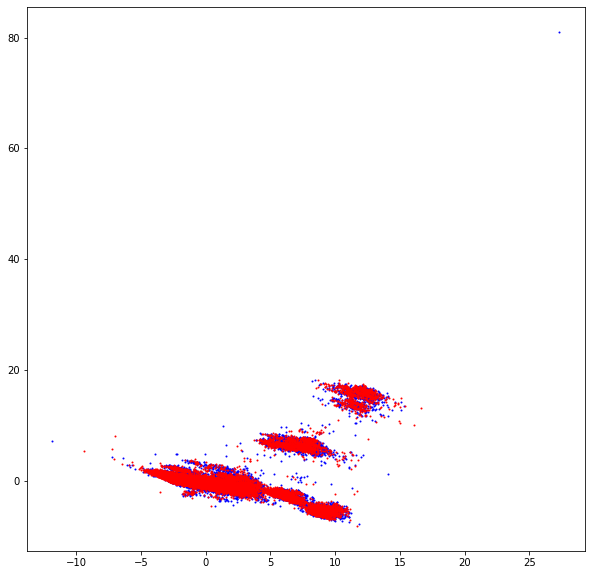

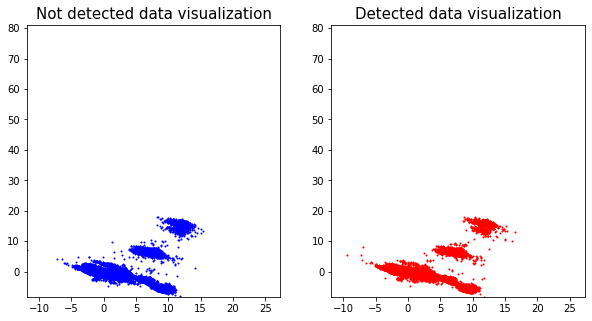

In [50]:
model = PCA(n_components=2)

train_pca_visual = np.array(model.fit_transform(normalized_train_features))

# when train_label == 1, then malware was detected
# when train_label == 0, malware was NOT detected

plt.figure(figsize=(10,10))

plt.plot(train_pca_visual[:,0][train_labels==0], train_pca_visual[:,1][train_labels==0], 'bo', markersize=1)
plt.plot(train_pca_visual[:,0][train_labels==1], train_pca_visual[:,1][train_labels==1], 'ro', markersize=1)


plt.figure(figsize=(10,5))
for i in range(2):
    color = 'bo' if i == 0 else 'ro'
    title = "Not detected data visualization" if i == 0 else "Detected data visualization"
    plt.subplot(1, 2, i + 1)
    plt.plot(train_pca_visual[:,0][train_labels==i], train_pca_visual[:,1][train_labels==i], color, markersize=1)
    plt.title(title, fontsize = 15)
    plt.ylim(train_pca_visual[:,1].min(), train_pca_visual[:,1].max())
    plt.xlim(train_pca_visual[:,0].min(), train_pca_visual[:,0].max())


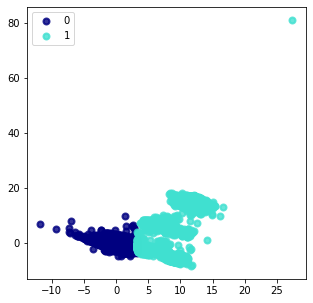

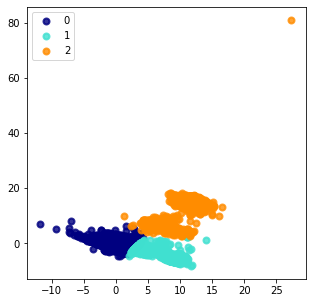

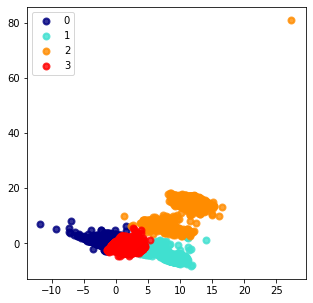

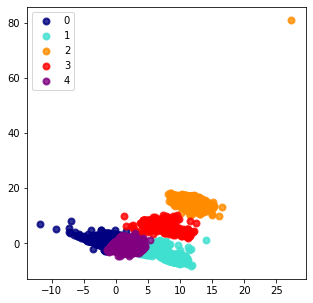

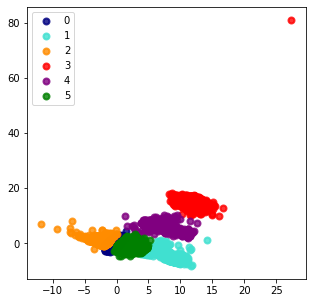

In [51]:
# Apply k-means + PCA + plot

from sklearn.cluster import KMeans

model = PCA(n_components=2)

train_pca = np.array(model.fit_transform(normalized_train_features))

colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple', 'green', 'black']

for k in range(2,7):
    # Fit the training data to a k-means clustering estimator model
    kmeans = KMeans(n_clusters=k).fit(train_pca)

    # Retrieve the labels assigned to each training sample
    kmeans_y = kmeans.labels_
    
    plt.figure(figsize=(5,5))
    for color, cat in zip(colors, range(k)):
        plt.scatter(train_pca[kmeans_y==cat, 0],
                train_pca[kmeans_y==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.show()

In [46]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis



Automatically created module for IPython interactive environment


In [ ]:
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

results = {}
print('Testing algorithms using normalized original dataset...\n')

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(normalized_train_features, train_labels)
    score = clf.score(normalized_test_features, test_labels)
    print("%s : %f %%" % (name, score*100))
    results[name] = score
    
winner = max(results, key=results.get)
print()
print(f'Winning algorithm is {winner} with a {results[winner]*100}% accuracy')    

Testing algorithms using normalized original dataset...

Nearest Neighbors : 56.190000 %
